# Projet 7: Preuve de concept

## contexte :
Utiliser les Transformers sur des données tabulées comme proposé par Huang et al, 2020
Utilisation d'une base de données réelles créées à partir de données publiques télécheargeables sur data.gouv.fr
A partir de cette base de données, des modèles seront créés afin de prédire le prix de l'immobilier en Ile de France.
Des modèles "baseline" seront utilisés pour conclure sur l'efficacité du TabTransformer.

## démarches
- télécharger les données
- nettoyage et exploration
- combiner l'ensemble des données
- créer de nouvelles variables
- Modélisation

# Notebook de modélisation
Dans ce notebook, les modèles seront créés dans le but de caractériser l'efficacité du TabTransformer

## Modules Python

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, dummy, metrics, linear_model, neighbors, kernel_ridge, svm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential

## Fonctions utiles 

In [2]:
def adjusted_r2(ytrue, ypred, k) :
    r2 = metrics.r2_score(ytrue, ypred)
    return 1-((1-r2)*(len(ytrue)-1)/(len(ytrue-k-1)))

## Chargement de la base de données néttoyée

In [3]:
DATA = pd.read_csv("database_training.csv", sep=",")
DATA.head()

,id_mutation,surface_reelle_bati,valeur_fonciere,nombre_lots,n_lignes,nombre_pieces_principales,surface_terrain,longitude,latitude,nature_mutation,...,latitude_rad,dist_transport,mode_transport,dist_ecole_elementaire,dist_ecole_maternelle,dist_college,dist_lycee,dist_univ,n_etudiants_10km,n_etab_sup_10km
0,2017-1258468,28.0,70500.0,2,2,1.0,0.0,2.479872,48.597344,Vente,...,0.848184,1.226445,RER,0.090434,0.095905,0.601269,1.330842,4.761447,9791.125,2
1,2017-1258471,48.0,82000.0,2,1,3.0,0.0,2.476406,48.616450,Vente,...,0.848517,0.421998,RER,0.382550,0.441427,0.952330,0.928192,3.437943,9791.125,2
2,2017-1258488,48.0,107000.0,2,2,2.0,0.0,2.486500,48.602800,Vente,...,0.848279,1.546433,RER,0.719328,0.255443,0.857166,0.764777,4.776014,9791.125,2
3,2017-1258494,34.0,86500.0,1,1,2.0,0.0,2.476223,48.603752,Vente,...,0.848296,1.031902,RER,0.541297,0.533212,0.624750,0.763896,4.097520,9791.125,2
4,2017-1258500,64.0,103000.0,3,1,3.0,0.0,2.481939,48.610506,Vente,...,0.848413,0.737474,RER,0.198185,0.670935,0.277279,0.155668,4.063263,9791.125,2


## Vérifications des valeurs non renseignées

In [4]:
DATA.isna().sum()

id_mutation                      0
surface_reelle_bati              0
valeur_fonciere                  0
nombre_lots                      0
n_lignes                         0
nombre_pieces_principales        0
surface_terrain                  0
longitude                        0
latitude                         0
nature_mutation                  0
CODGEO                           0
Dépendance                       0
type_local                       0
année                            0
mois                             0
n_days                           0
LIBGEO                           0
DEP                              0
Score Synergie Médicale          0
Score équipement de santé BV     0
Score Démographique              0
Evolution Pop %                  0
Dynamique Démographique INSEE    0
Taux Propriété                   0
loyer_moyen                      0
loyer_min                        0
loyer_max                        0
longitude_rad                    0
latitude_rad        

Aucune valeur n'est manquante.

## Suppression variables inutilisées
Parmis les variables disponibles dans la base de données, certaines ont servi à la création de celle ci, mais ne seront pas utilisées ensuite pour la modélisation : on les supprime.

In [5]:
rm_var = ['latitude_rad', 'longitude_rad', 'id_mutation', 'LIBGEO', 'nombre_lots', 'n_lignes', 'DEP'] 
for var in rm_var :
    if var in DATA.columns :
        DATA.drop(var, axis='columns', inplace=True)

In [6]:
print(f"Nombre d'observations dans la base de données finale : {len(DATA)}")
print(f"Nombre de variables dans la base de données finale : {len(DATA.columns)}")

Nombre d'observations dans la base de données finale : 79593
Nombre de variables dans la base de données finale : 31


## Encodage des variables

In [7]:
for var in ['nombre_pieces_principales', 'Dépendance'] :
    DATA[var] = DATA[var].astype(np.int64)

In [8]:
DATA.dtypes

surface_reelle_bati              float64
valeur_fonciere                  float64
nombre_pieces_principales          int64
surface_terrain                  float64
longitude                        float64
latitude                         float64
nature_mutation                   object
CODGEO                             int64
Dépendance                         int64
type_local                        object
année                              int64
mois                               int64
n_days                             int64
Score Synergie Médicale          float64
Score équipement de santé BV       int64
Score Démographique              float64
Evolution Pop %                    int64
Dynamique Démographique INSEE      int64
Taux Propriété                     int64
loyer_moyen                      float64
loyer_min                        float64
loyer_max                        float64
dist_transport                   float64
mode_transport                    object
dist_ecole_eleme

### nature_mutation

In [9]:
enc_nat_mut  = LabelEncoder()
enc_nat_mut.fit(DATA['nature_mutation'])
DATA['nature_mutation_enc'] = enc_nat_mut.transform(DATA['nature_mutation'])
print(f"Classe de l'encoder : {enc_nat_mut.classes_}")

Classe de l'encoder : ['Adjudication' 'Echange' 'Vente' "Vente en l'état futur d'achèvement"]


### type_local

In [10]:
enc_local  = LabelEncoder()
enc_local.fit(DATA['type_local'])
DATA['type_local_enc'] = enc_local.transform(DATA['type_local'])
print(f"Classe de l'encoder : {enc_local.classes_}")

Classe de l'encoder : ['Appartement' 'Maison']


### mode_transport

In [11]:
enc_transp = LabelEncoder()
enc_transp.fit(DATA['mode_transport'])
DATA['mode_transport_enc'] = enc_transp.transform(DATA['mode_transport'])
print(f"Classe de l'encoder : {enc_transp.classes_}")

Classe de l'encoder : ['RER' 'TRAIN' 'TRAMWAY' 'VAL']


### CODGEO

In [12]:
enc_codgeo = LabelEncoder()
enc_codgeo.fit(DATA['CODGEO'])
DATA['CODGEO_enc'] = enc_codgeo.transform(DATA['CODGEO'])
print(f"Classe de l'encoder : {enc_codgeo.classes_}")

Classe de l'encoder : [91001 91016 91017 91021 91022 91027 91035 91037 91038 91041 91044 91045
 91047 91064 91067 91069 91075 91079 91080 91081 91085 91086 91093 91095
 91097 91098 91099 91100 91103 91105 91106 91109 91111 91112 91114 91115
 91121 91122 91129 91130 91131 91132 91135 91136 91137 91145 91148 91156
 91159 91161 91174 91175 91179 91180 91184 91186 91191 91195 91198 91200
 91201 91204 91207 91215 91216 91223 91225 91226 91228 91232 91235 91240
 91243 91244 91247 91248 91249 91272 91273 91274 91275 91284 91286 91292
 91293 91294 91312 91315 91318 91319 91326 91330 91332 91333 91338 91339
 91340 91345 91347 91359 91363 91374 91376 91377 91378 91386 91390 91393
 91399 91405 91408 91411 91412 91414 91421 91425 91432 91433 91434 91435
 91441 91457 91458 91461 91463 91468 91469 91471 91473 91477 91479 91482
 91494 91495 91507 91508 91511 91514 91519 91521 91525 91526 91533 91534
 91538 91540 91544 91546 91547 91549 91552 91553 91556 91560 91568 91570
 91573 91577 91578 91579 9158

## Correlation entre variables

In [13]:
DATA.corr(method='pearson', min_periods=50)

,surface_reelle_bati,valeur_fonciere,nombre_pieces_principales,surface_terrain,longitude,latitude,CODGEO,Dépendance,année,mois,...,dist_ecole_maternelle,dist_college,dist_lycee,dist_univ,n_etudiants_10km,n_etab_sup_10km,nature_mutation_enc,type_local_enc,mode_transport_enc,CODGEO_enc
surface_reelle_bati,1.000000,0.714283,0.845835,0.527716,-0.081185,-0.061831,0.040429,-0.316136,0.007921,0.008536,...,0.148554,0.144241,0.131002,0.057321,-0.070239,-0.011399,-0.127364,0.564027,-0.000654,0.038471
valeur_fonciere,0.714283,1.000000,0.632524,0.544363,-0.115662,0.183370,0.118796,-0.314596,0.095078,0.037389,...,0.093490,0.043439,0.009937,-0.098776,0.014774,0.227029,-0.007643,0.614479,0.012553,0.113309
nombre_pieces_principales,0.845835,0.632524,1.000000,0.466640,-0.044107,-0.036541,0.044345,-0.321342,0.005077,0.008932,...,0.102946,0.102572,0.098148,0.032989,-0.043398,-0.013596,-0.127858,0.567356,-0.003932,0.042083
surface_terrain,0.527716,0.544363,0.466640,1.000000,-0.097381,-0.201101,0.025579,-0.406261,0.044334,0.026981,...,0.257558,0.268168,0.263940,0.200113,-0.101425,-0.140188,-0.129220,0.681566,0.041650,0.021703
longitude,-0.081185,-0.115662,-0.044107,-0.097381,1.000000,0.239352,0.017282,0.044798,-0.006774,-0.005944,...,-0.162074,-0.276658,-0.288217,-0.429490,0.468848,-0.154235,0.005309,-0.079514,-0.072291,0.020005
latitude,-0.061831,0.183370,-0.036541,-0.201101,0.239352,1.000000,0.247483,0.122466,-0.015574,-0.012992,...,-0.298330,-0.489101,-0.635372,-0.756037,0.411771,0.601119,0.011697,-0.170917,-0.047034,0.248391
CODGEO,0.040429,0.118796,0.044345,0.025579,0.017282,0.247483,1.000000,-0.020551,-0.000286,-0.004404,...,-0.024429,-0.061089,-0.049474,-0.178851,0.192528,0.225821,-0.026040,0.054732,-0.107108,0.998861
Dépendance,-0.316136,-0.314596,-0.321342,-0.406261,0.044798,0.122466,-0.020551,1.000000,0.097120,0.033493,...,-0.120008,-0.136011,-0.148512,-0.139729,0.062993,0.100251,0.191439,-0.645337,-0.031699,-0.016796
année,0.007921,0.095078,0.005077,0.044334,-0.006774,-0.015574,-0.000286,0.097120,1.000000,0.003322,...,-0.002569,0.007120,0.012207,0.019552,-0.007424,-0.014851,-0.076847,0.010370,0.002853,-0.000510
mois,0.008536,0.037389,0.008932,0.026981,-0.005944,-0.012992,-0.004404,0.033493,0.003322,1.000000,...,0.007006,0.009092,0.008049,0.009002,-0.006783,-0.003935,0.035595,0.015305,-0.000893,-0.004242


In [14]:
df_corr = DATA.corr(method='spearman', min_periods=50)
df_corr = df_corr*df_corr

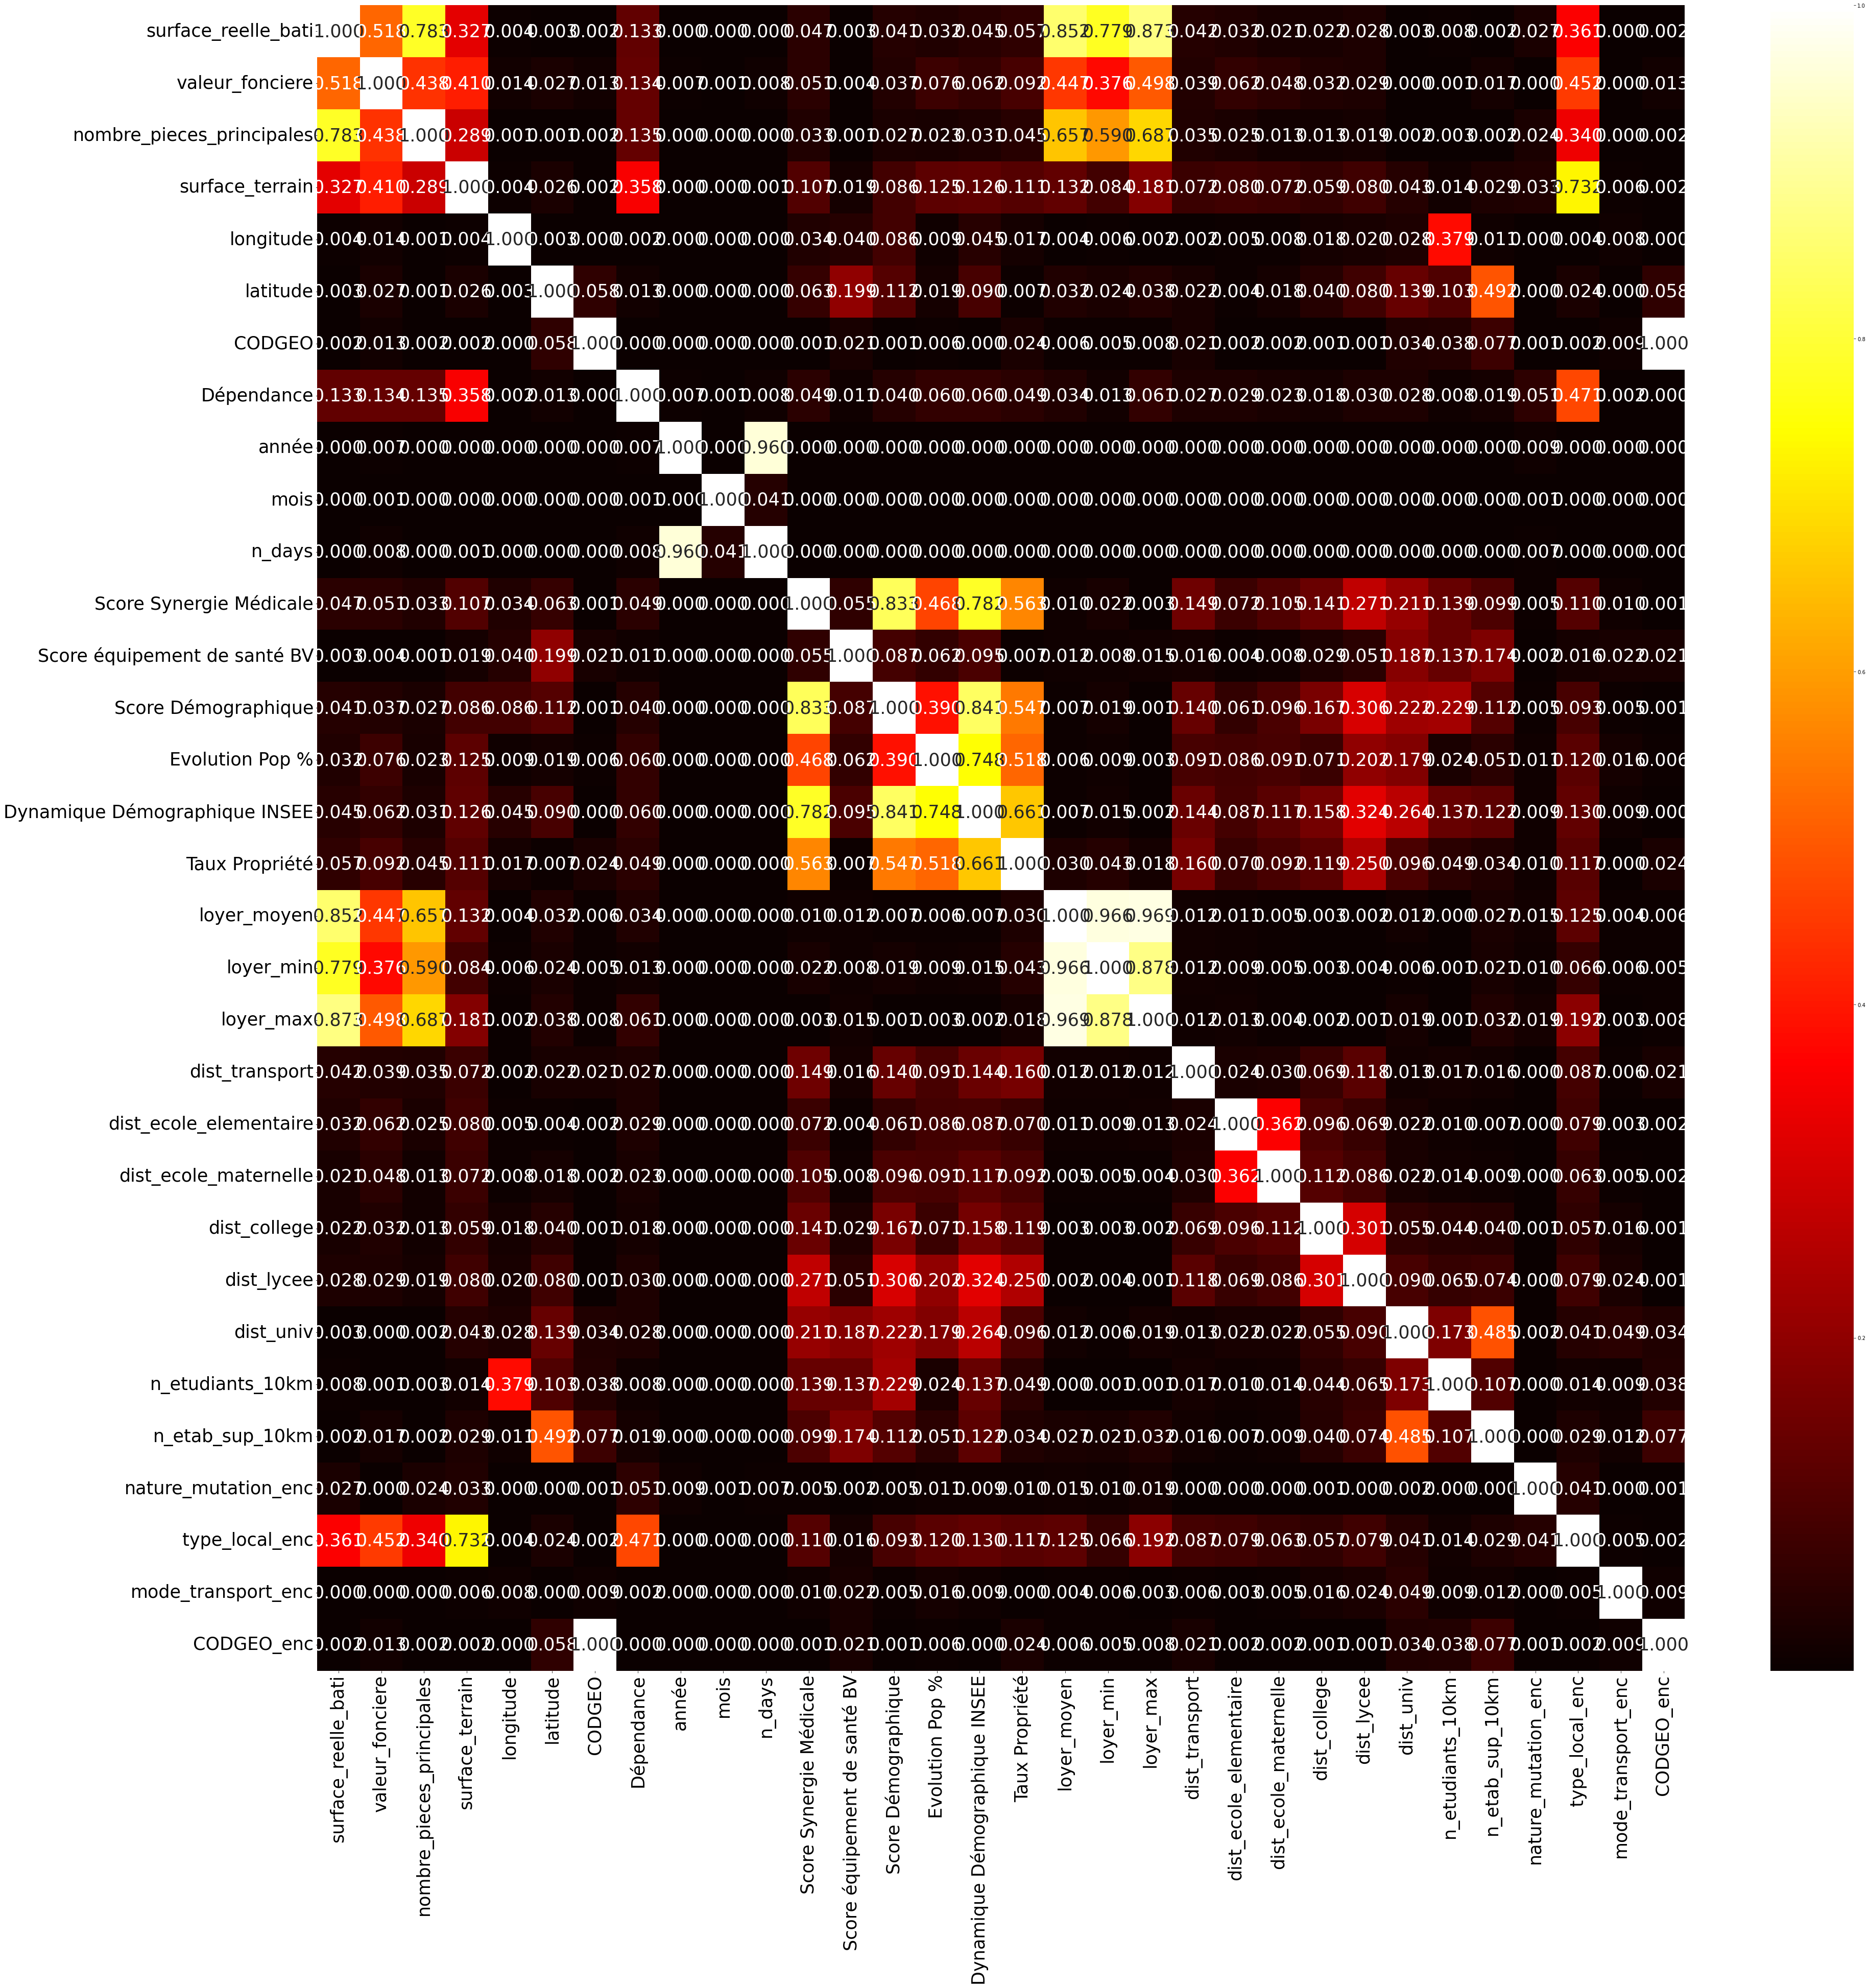

In [15]:
fig, ax = plt.subplots(figsize=(60,60))     
m = sns.heatmap(df_corr, annot=True,ax=ax, fmt=".3f", cmap="hot", annot_kws={"size": 35})
m.set_xticklabels(m.get_xmajorticklabels(), fontsize = 35)
m.set_yticklabels(m.get_ymajorticklabels(), fontsize = 35)
plt.show()

Les variables sont plus ou moins corrélées entre elles : 
- la valeur foncière (valeur à prédire) est fortement corrélée à la surface habitable, au nombre de pièces, à la surface du terrain, au montant estimé du loyer et au type de l'habitation.
- les montants des loyers prédits sont fortement corrélés avec la surface, le nombre de pièces et le nombre d'appartements. Cela se comprend puisque le loyer est une combinaison linéaire de la surface par un facteur multiplicatif dépendant de la commune. Cela signifie qu'en Essonne ce facteur est presque constant.
- le nombre de pièces est fortement corrélé à la surface, à a surface du terrain et au loyer et au type d'habitation
- les données propres à la commune sont tous corrélées entre elles.
- les distances entre les établissements scolaires sont légérement corrélées également
- le nombre de jours depuis la mutation est corrélé à l'année.

## préparation des variables

In [16]:
DATA.columns

Index(['surface_reelle_bati', 'valeur_fonciere', 'nombre_pieces_principales',
       'surface_terrain', 'longitude', 'latitude', 'nature_mutation', 'CODGEO',
       'Dépendance', 'type_local', 'année', 'mois', 'n_days',
       'Score Synergie Médicale', 'Score équipement de santé BV',
       'Score Démographique', 'Evolution Pop %',
       'Dynamique Démographique INSEE', 'Taux Propriété', 'loyer_moyen',
       'loyer_min', 'loyer_max', 'dist_transport', 'mode_transport',
       'dist_ecole_elementaire', 'dist_ecole_maternelle', 'dist_college',
       'dist_lycee', 'dist_univ', 'n_etudiants_10km', 'n_etab_sup_10km',
       'nature_mutation_enc', 'type_local_enc', 'mode_transport_enc',
       'CODGEO_enc'],
      dtype='object')

On supprime du jeu de données les variables trop corrélées entre elles, car cela n'apportera aucune précision supplémentaire au modèle ainsi que les variables encodées.
Les variables supprimées sont :
- loyer_min, loyer_max
- Score Synergie Médicale
- n_days
- nature_mutation, type_local, CODGEO, mode_transport

In [17]:
Y = DATA['valeur_fonciere']
rm_var = ['valeur_fonciere', 'loyer_min', 'loyer_max', 'n_days', 'Score Synergie Médicale', 'nature_mutation',
         'type_local', 'CODGEO', 'mode_transport']
#c = [col for col in DATA.columns if col not in rm_var ]
#DATA[c]
X = DATA[[col for col in DATA.columns if col not in rm_var ]]

In [18]:
print(f"Nombre de variables : {len(X.columns)}")
print(f"Liste des variables : {', '.join(X.columns)}")

Nombre de variables : 26
Liste des variables : surface_reelle_bati, nombre_pieces_principales, surface_terrain, longitude, latitude, Dépendance, année, mois, Score équipement de santé BV, Score Démographique, Evolution Pop %, Dynamique Démographique INSEE, Taux Propriété, loyer_moyen, dist_transport, dist_ecole_elementaire, dist_ecole_maternelle, dist_college, dist_lycee, dist_univ, n_etudiants_10km, n_etab_sup_10km, nature_mutation_enc, type_local_enc, mode_transport_enc, CODGEO_enc


In [19]:
categ_types = ['int16', 'int32', 'int64']
categ_var = list(X.select_dtypes(include=categ_types).columns)
print(f"Nombre de variables catégorielles : {len(categ_var)}")
print(f"Liste des variables de catégories : {', '.join(categ_var)}")

Nombre de variables catégorielles : 13
Liste des variables de catégories : nombre_pieces_principales, Dépendance, année, mois, Score équipement de santé BV, Evolution Pop %, Dynamique Démographique INSEE, Taux Propriété, n_etab_sup_10km, nature_mutation_enc, type_local_enc, mode_transport_enc, CODGEO_enc


In [20]:
cont_types = ['float16', 'float32', 'float64']
cont_var = list(X.select_dtypes(include=cont_types).columns)
print(f"Nombre de variables catégorielles : {len(cont_var)}")
print(f"Liste des variables de catégories : {', '.join(cont_var)}")

Nombre de variables catégorielles : 13
Liste des variables de catégories : surface_reelle_bati, surface_terrain, longitude, latitude, Score Démographique, loyer_moyen, dist_transport, dist_ecole_elementaire, dist_ecole_maternelle, dist_college, dist_lycee, dist_univ, n_etudiants_10km


## Préparation jeu d'apprentissage et de test

### séparation des données

In [21]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)

In [22]:
print(f"Nombre d'observations dans le jeu d'apprentissage : {len(X_train)}")
print(f"Nombre d'observations dans le jeu de test : {len(X_test)}")

Nombre d'observations dans le jeu d'apprentissage : 63674
Nombre d'observations dans le jeu de test : 15919


### Scaler

In [23]:
preprocessor = ColumnTransformer(remainder='passthrough', 
                                transformers=[
                                    ('std', StandardScaler() , cont_var)
                                ]
                                )

In [24]:
preprocessor.fit(X_train)
X_train_norm = preprocessor.transform(X_train)
X_test_norm = preprocessor.transform(X_test)

In [25]:
#scaler = StandardScaler()
#scaler.fit(X_train)
#X_train_norm = scaler.transform(X_train)
#X_test_norm = scaler.transform(X_test)

## Baseline

In [26]:
baseline = dummy.DummyRegressor(strategy="mean")
baseline.fit(X_train_norm, Y_train)
mae = metrics.mean_absolute_error(Y_train, baseline.predict(X_train_norm))
print(f"Dummy mean : MAE = {mae} €")

Dummy mean : MAE = 92430.61352923585 €


Les modèles ayant une erreur absolue moyenne proche de 92k n'auront appris que la moyenne.

## Test de différents modèles
Différents modèles implémentés dans Sklearn sont testés afin d'obtenir une estimation des performances accessibles grâce à des modèles simples avant de tester les transformers

In [27]:
models = []
models.append(('ElasticNet', linear_model.ElasticNet()))
models.append(('KNN', neighbors.KNeighborsRegressor()))
#models.append(('Kernel Ridge', kernel_ridge.KernelRidge()))
models.append(('Ker SVR', svm.SVR(kernel="rbf")))
models.append(("XGBoost", xgb.XGBRegressor()))
names = [model[0] for model in models]

In [28]:
n_fold = 5
seed=42
n_job = 4
scoring = "neg_mean_absolute_error"
kfold = model_selection.KFold(n_splits=n_fold, random_state=seed, shuffle=True)

for name, model in models :
    print("="*30)
    print(name)
    print("="*30)
    cv_results = model_selection.cross_val_score(model, X_train_norm, Y_train, \
                                                 cv=kfold, scoring=scoring, n_jobs=n_job)
    print(f"Mean Absolute Error = {cv_results.mean():10.3f} ({cv_results.std():10.3f}) ")
#y_pred = model_selection.cross_val_predict(model, X_train_norm, Y_train, cv=kfold, n_jobs=n_job)
#print(f"Mean Absolute Error = {cv_results.mean():10.3f} ({cv_results.std():10.3f}) ")

ElasticNet
Mean Absolute Error = -47833.214 (   520.952) 
KNN
Mean Absolute Error = -40992.625 (   406.585) 
Ker SVR
Mean Absolute Error = -91021.884 (   639.985) 
XGBoost
Mean Absolute Error = -32808.525 (   255.081) 


Les meilleurs performances sont obtenues avec un modèle XGBoost

In [27]:
result = pd.DataFrame(columns=['model', 'MAE_train', 'MAE_test', 'R2_train', 'R2_test', 'y_train_pred', 'y_pred_test'])

In [28]:
name = "XGBoost"
model = xgb.XGBRegressor()
model.fit(X_train_norm, Y_train)
y_pred = model.predict(X_train_norm)
y_test_pred = model.predict(X_test_norm)
MAE_train = metrics.mean_absolute_error(Y_train, y_pred)
MAE_test = metrics.mean_absolute_error(Y_test, y_test_pred)
R2_train = adjusted_r2(Y_train, y_pred, X_train_norm.shape[0])
R2_test = adjusted_r2(Y_test, y_test_pred, X_test_norm.shape[0])
print(f"Mean absolute Error train set = {MAE_train}")
print(f"Mean absolute Error test set = {MAE_test}")
print(f"Adjusted R2 train set = {R2_train}")
print(f"Adjusted R2 Error train set = {R2_test}")
print(f"Mean percentage error train set = {metrics.mean_absolute_percentage_error(Y_train, y_pred)}")
print(f"Mean percentage error test set = {metrics.mean_absolute_percentage_error(Y_test, y_test_pred)}")

result.drop(result[result['model']==name].index, inplace=True)
result = result.append({'model':name,
                        'MAE_train':MAE_train , 'MAE_test':MAE_test, 
                        'R2_train': R2_train, 'R2_test':R2_test,
                       'y_train_pred': y_pred, 'y_pred_test':y_test_pred}, ignore_index=True)

Mean absolute Error train set = 28113.012247387724
Mean absolute Error test set = 32392.95629276042
Adjusted R2 train set = 0.8747749710036515
Adjusted R2 Error train set = 0.8087128183359469
Mean percentage error train set = 0.14947168532717336
Mean percentage error test set = 0.1711220093177578


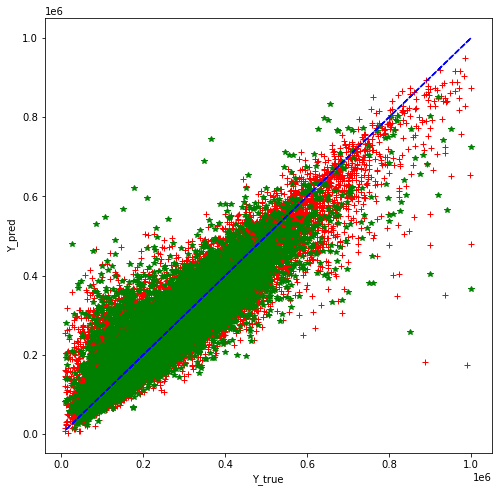

In [29]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(Y_train, y_pred, marker='+', linestyle="", color="red")
ax.plot(Y_test, y_test_pred, marker='*', linestyle="", color="green")
ax.plot(Y_train, Y_train, linestyle="--", color="blue")
#ax.set_xlim([-1e6, 1e7])
#ax.set_ylim([-1e6, 1e7])
ax.set_xlabel("Y_true")
ax.set_ylabel("Y_pred")
plt.show()

### Optimisation des hyperparamètres

In [78]:
n_fold = 4
#param = { "learning_rate" : np.arange(0,0.6, 0.2), 'max_depth': range(1,30,5), "subsample": np.arange(0.6,1.1,0.2), \
#         'colsample_bytree': np.arange(0.6,1.1,0.2), 'n_estimators':range(100, 400, 50) }
param = {'n_estimators':range(100, 400, 100),
        'max_depth': range(1,30,5)}
model = xgb.XGBRegressor()
kfold = model_selection.KFold(n_splits=n_fold, random_state=seed, shuffle=True)
grid = model_selection.GridSearchCV(estimator=model, param_grid=param, scoring=scoring, cv=kfold, n_jobs=n_job, verbose=2)
result = grid.fit(X_train_norm, Y_train)
print(f"Best result : {result.best_score_} with {result.best_params_}")

Fitting 4 folds for each of 18 candidates, totalling 72 fits
Best result : -32604.00945280827 with {'max_depth': 6, 'n_estimators': 300}


In [30]:
name = "XGBoost_opt"
model = xgb.XGBRegressor(n_estimators=300, max_depth=6)
model.fit(X_train_norm, Y_train)
y_pred = model.predict(X_train_norm)
y_test_pred = model.predict(X_test_norm)
MAE_train = metrics.mean_absolute_error(Y_train, y_pred)
MAE_test = metrics.mean_absolute_error(Y_test, y_test_pred)
R2_train = adjusted_r2(Y_train, y_pred, X_train_norm.shape[0])
R2_test = adjusted_r2(Y_test, y_test_pred, X_test_norm.shape[0])
print(f"Mean absolute Error train set = {MAE_train}")
print(f"Mean absolute Error test set = {MAE_test}")
print(f"Adjusted R2 train set = {R2_train}")
print(f"Adjusted R2 Error train set = {R2_test}")
print(f"Mean percentage error train set = {metrics.mean_absolute_percentage_error(Y_train, y_pred)}")
print(f"Mean percentage error test set = {metrics.mean_absolute_percentage_error(Y_test, y_test_pred)}")

result.drop(result[result['model']==name].index, inplace=True)
result = result.append({'model':name,
                        'MAE_train':MAE_train , 'MAE_test':MAE_test, 
                        'R2_train': R2_train, 'R2_test':R2_test,
                       'y_train_pred': y_pred, 'y_pred_test':y_test_pred}, ignore_index=True)

Mean absolute Error train set = 22505.54521465127
Mean absolute Error test set = 31863.70597764218
Adjusted R2 train set = 0.9232786724542763
Adjusted R2 Error train set = 0.8080175533995437
Mean percentage error train set = 0.1213924911126196
Mean percentage error test set = 0.16725263573239488


### CatBoost

In [31]:
from catboost import Pool, CatBoostRegressor

In [32]:
categ_var_i = []
for var in categ_var : 
    categ_var_i.append(X.columns.get_loc(var))

In [33]:
train_pool = Pool(X_train, 
                  Y_train, 
                  cat_features=categ_var_i)
test_pool = Pool(X_test, 
                 Y_test,
                 cat_features=categ_var_i) 

In [145]:
for depth in [1,5,10, 16] :
    for lr in [0.05, 0.1, 0.2, 0.5] :
        model = CatBoostRegressor(iterations=500, 
                                  depth=depth, 
                                  learning_rate=lr, 
                                  loss_function='MAE',
                                  verbose=0,
                                  #loss_function=metrics.mean_absolute_percentage_error,
                                  use_best_model=True)
        print("="*50)
        print(f"Depth = {depth}, learning rate = {lr}")
        model.fit(train_pool, eval_set=test_pool)
        y_pred = model.predict(train_pool)
        y_test_pred = model.predict(test_pool)
        print(f"Mean absolute Error train set = {metrics.mean_absolute_error(Y_train, y_pred)}")
        print(f"Mean absolute Error test set = {metrics.mean_absolute_error(Y_test, y_test_pred)}")
        print(f"Adjusted R2 train set = {adjusted_r2(Y_train, y_pred, X_train.shape[0])}")
        print(f"Adjusted R2 Error train set = {adjusted_r2(Y_test, y_test_pred, X_test.shape[0])}")

Depth = 1, learning rate = 0.05
Mean absolute Error train set = 40261.13527102458
Mean absolute Error test set = 40123.46513074812
Adjusted R2 train set = 0.7383773427608529
Adjusted R2 Error train set = 0.7417990874104687
Depth = 1, learning rate = 0.1
Mean absolute Error train set = 39116.671910420824
Mean absolute Error test set = 39037.794438186036
Adjusted R2 train set = 0.7541373846538801
Adjusted R2 Error train set = 0.7563203507725074
Depth = 1, learning rate = 0.2
Mean absolute Error train set = 38648.740124497745
Mean absolute Error test set = 38652.02998311004
Adjusted R2 train set = 0.7603394644706607
Adjusted R2 Error train set = 0.7615350880784557
Depth = 1, learning rate = 0.5
Mean absolute Error train set = 37914.12311837769
Mean absolute Error test set = 37952.1970449457
Adjusted R2 train set = 0.7692643863938926
Adjusted R2 Error train set = 0.7694491831020198
Depth = 5, learning rate = 0.05
Mean absolute Error train set = 32953.77556530254
Mean absolute Error test se

In [34]:
name = 'cateboost'
model = CatBoostRegressor(iterations=1000, 
                                  depth=10, 
                                  learning_rate=0.1, 
                                  loss_function='MAE',
                                  verbose=0,
                                  #loss_function=metrics.mean_absolute_percentage_error,
                                  use_best_model=True)
model.fit(train_pool, eval_set=test_pool)
y_pred = model.predict(train_pool)
y_test_pred = model.predict(test_pool)
MAE_train = metrics.mean_absolute_error(Y_train, y_pred)
MAE_test = metrics.mean_absolute_error(Y_test, y_test_pred)
R2_train = adjusted_r2(Y_train, y_pred, X_train_norm.shape[0])
R2_test = adjusted_r2(Y_test, y_test_pred, X_test_norm.shape[0])
print(f"Mean absolute Error train set = {MAE_train}")
print(f"Mean absolute Error test set = {MAE_test}")
print(f"Adjusted R2 train set = {R2_train}")
print(f"Adjusted R2 Error train set = {R2_test}")
print(f"Mean percentage error train set = {metrics.mean_absolute_percentage_error(Y_train, y_pred)}")
print(f"Mean percentage error test set = {metrics.mean_absolute_percentage_error(Y_test, y_test_pred)}")

result.drop(result[result['model']==name].index, inplace=True)
result = result.append({'model':name,
                        'MAE_train':MAE_train , 'MAE_test':MAE_test, 
                        'R2_train': R2_train, 'R2_test':R2_test,
                       'y_train_pred': y_pred, 'y_pred_test':y_test_pred}, ignore_index=True)

Mean absolute Error train set = 24971.590566539926
Mean absolute Error test set = 30711.336680433258
Adjusted R2 train set = 0.8722320504756148
Adjusted R2 Error train set = 0.816633471768771
Mean percentage error train set = 0.13366264130515568
Mean percentage error test set = 0.163682365708065


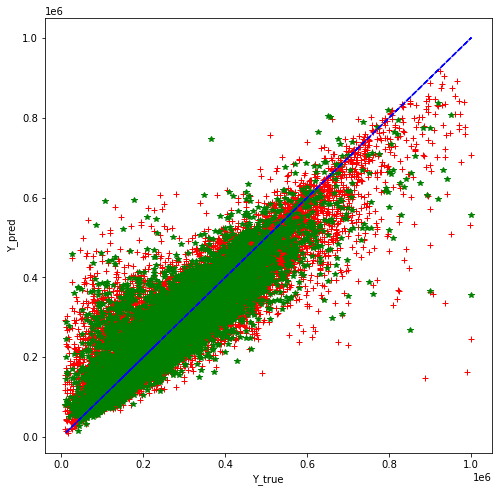

In [35]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(Y_train, y_pred, marker='+', linestyle="", color="red")
ax.plot(Y_test, y_test_pred, marker='*', linestyle="", color="green")
ax.plot(Y_train, Y_train, linestyle="--", color="blue")
#ax.set_xlim([-1e6, 1e7])
#ax.set_ylim([-1e6, 1e7])
ax.set_xlabel("Y_true")
ax.set_ylabel("Y_pred")
plt.show()

## Réseau de neurones

In [36]:
def create_nn(inputshape, outputshape, nlayers=2, nneuron=64) :
    model = Sequential()
    model.add(layers.Dense(nneuron, activation='relu', input_shape=(inputshape,)))
    for _ in range(1, nlayers) :
       model.add(layers.Dense(nneuron, activation='relu'))
    model.add(layers.Dense(outputshape))
    return model

In [37]:
for couche in [2, 5, 10, 15] :
    for neurones in [32, 64, 128, 256] :
        name = f'NN_l-{couche}_n-{neurones}'
        print(couche, neurones)
        model = create_nn(26, 1, nlayers=couche, nneuron=neurones)
        model.compile(optimizer='adam',
                      loss="mean_absolute_error",
                      metrics=['accuracy'])
        history = model.fit(X_train_norm, Y_train, 
                            validation_data=(X_test_norm, Y_test),
                            batch_size=128,
                            epochs=50,
                            verbose=0)
        
        y_pred = model.predict(X_train_norm)
        y_test_pred = model.predict(X_test_norm)
        MAE_train = metrics.mean_absolute_error(Y_train, y_pred)
        MAE_test = metrics.mean_absolute_error(Y_test, y_test_pred)
        R2_train = adjusted_r2(Y_train, y_pred, X_train_norm.shape[0])
        R2_test = adjusted_r2(Y_test, y_test_pred, X_test_norm.shape[0])
        print(f"Mean absolute Error train set = {MAE_train}")
        print(f"Mean absolute Error test set = {MAE_test}")
        print(f"Adjusted R2 train set = {R2_train}")
        print(f"Adjusted R2 Error train set = {R2_test}")
        print(f"Mean percentage error train set = {metrics.mean_absolute_percentage_error(Y_train, y_pred)}")
        print(f"Mean percentage error test set = {metrics.mean_absolute_percentage_error(Y_test, y_test_pred)}")

        result.drop(result[result['model']==name].index, inplace=True)
        result = result.append({'model':name,
                                'MAE_train':MAE_train , 'MAE_test':MAE_test, 
                                'R2_train': R2_train, 'R2_test':R2_test,
                                'y_train_pred': y_pred, 'y_pred_test':y_test_pred}, ignore_index=True)

2 32
Mean absolute Error train set = 45098.32845512641
Mean absolute Error test set = 44275.274944111596
Adjusted R2 train set = 0.708554559848198
Adjusted R2 Error train set = 0.7050637927855643
Mean percentage error train set = 0.23697064715445
Mean percentage error test set = 0.23348506200226488
2 64
Mean absolute Error train set = 42782.142718355906
Mean absolute Error test set = 42071.745242143814
Adjusted R2 train set = 0.7291901285216636
Adjusted R2 Error train set = 0.726506896247979
Mean percentage error train set = 0.2283548646414866
Mean percentage error test set = 0.22530423333507718
2 128
Mean absolute Error train set = 40722.41155757011
Mean absolute Error test set = 40045.19742796541
Adjusted R2 train set = 0.7486864948444538
Adjusted R2 Error train set = 0.7460545288642086
Mean percentage error train set = 0.21995137845951296
Mean percentage error test set = 0.2175391012642148
2 256
Mean absolute Error train set = 39671.270921817086
Mean absolute Error test set = 39025.

Le meilleur résultat est obtenu avec 256 neurones et 15 couches ou 10 couches et 128 neurones. On conserve uniquement ce résultat.

In [39]:
result

,model,MAE_train,MAE_test,R2_train,R2_test,y_train_pred,y_pred_test
0,XGBoost,28113.012247,32392.956293,0.874775,0.808713,"[237445.19, 71319.25, 137155.17, 278218.84, 38...","[407748.16, 235161.02, 103339.07, 265884.8, 33..."
1,XGBoost_opt,22505.545215,31863.705978,0.923279,0.808018,"[238209.48, 89065.734, 135762.5, 274853.75, 38...","[407152.12, 238140.97, 104171.91, 262500.25, 3..."
2,cateboost,24971.590567,30711.336680,0.872232,0.816633,"[242020.15824361675, 86352.32808918788, 130867...","[379793.8524331677, 245418.51505245434, 94961...."
13,NN_l-10_n-128,37253.751704,36754.702748,0.776596,0.772241,"[[245355.98], [76420.2], [140200.34], [294752....","[[366981.56], [248575.64], [105731.375], [2433..."
18,NN_l-15_n-256,37138.422917,36896.194336,0.781828,0.774146,"[[257865.03], [83734.61], [144685.4], [292029....","[[386602.2], [266663.97], [104095.77], [254444..."


In [40]:
rm_i = []
for i in range(0, len(result)) :
    name = result.iloc[i]['model']
    if name.startswith('NN')  and name != 'NN_l-10_n-128' and name != 'NN_l-15_n-256':
        #print(result.iloc[i].name)
        rm_i.append(result.iloc[i].name)
result.drop(rm_i, inplace=True)


## TabMLP

In [41]:
from pytorch_widedeep.preprocessing import TabPreprocessor
from pytorch_widedeep import Trainer
from pytorch_widedeep.metrics import Accuracy
import torch
from torchvision.transforms import ToTensor
from pytorch_widedeep.callbacks import EarlyStopping,LRHistory
from pytorch_widedeep.initializers import KaimingNormal, KaimingUniform, Normal, Uniform
#deep_opt = torch.optim.AdamW(model.deeptabular.parameters())
#deep_sch = torch.optim.lr_scheduler.StepLR(deep_opt, step_size=3)
#optimizers = {"deeptabular": deep_opt}
#schedulers = {"deeptabular": deep_sch}
#initializers = {"wide": Uniform, "deeptabular": Normal, "deeptext": KaimingNormal, "deepimage": KaimingUniform}
#transforms = [ToTensor]
#callbacks = [LRHistory(n_epochs=4)]

cat_embed_cols = categ_var
continuous_cols = cont_var
target = Y_train.values

In [42]:
tab_preprocessor = TabPreprocessor(
    cat_embed_cols=cat_embed_cols, continuous_cols=continuous_cols  # type: ignore[arg-type]
)
X_tab = tab_preprocessor.fit_transform(X_train)

In [43]:
from pytorch_widedeep.models import TabMlp, WideDeep

tab_mlp = TabMlp(
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=continuous_cols,
    #mlp_hidden_dims=[200, 100]
)
model = WideDeep(deeptabular=tab_mlp)

In [44]:
trainer = Trainer(model, objective="mean_absolute_error", metrics=[Accuracy],
                 device='cpu', num_workers=4)
trainer.fit(
    X_tab=X_tab,
    target=target,
    n_epochs=10,
    batch_size=64,
    val_split=0.2
)

valid: 100%|██████████| 199/199 [00:36<00:00,  5.47it/s, loss=3.91e+4, metrics={'acc': 0.0}]


In [45]:
name = 'TabMLP'
y_pred = trainer.predict(X_tab = tab_preprocessor.transform(X_train))
y_test_pred = trainer.predict(X_tab = tab_preprocessor.transform(X_test))
MAE_train = metrics.mean_absolute_error(Y_train, y_pred)
MAE_test = metrics.mean_absolute_error(Y_test, y_test_pred)
R2_train = adjusted_r2(Y_train, y_pred, X_train_norm.shape[0])
R2_test = adjusted_r2(Y_test, y_test_pred, X_test_norm.shape[0])
print(f"Mean absolute Error train set = {MAE_train}")
print(f"Mean absolute Error test set = {MAE_test}")
print(f"Adjusted R2 train set = {R2_train}")
print(f"Adjusted R2 Error train set = {R2_test}")
print(f"Mean percentage error train set = {metrics.mean_absolute_percentage_error(Y_train, y_pred)}")
print(f"Mean percentage error test set = {metrics.mean_absolute_percentage_error(Y_test, y_test_pred)}")

result.drop(result[result['model']==name].index, inplace=True)
result = result.append({'model':name,
                        'MAE_train':MAE_train , 'MAE_test':MAE_test, 
                        'R2_train': R2_train, 'R2_test':R2_test,
                        'y_train_pred': y_pred, 'y_pred_test':y_test_pred}, ignore_index=True)

predict: 100%|██████████| 249/249 [00:37<00:00,  6.58it/s]


Mean absolute Error train set = 39778.239254652
Mean absolute Error test set = 39246.78699530905
Adjusted R2 train set = 0.750942319112735
Adjusted R2 Error train set = 0.7482708241423409
Mean percentage error train set = 0.20835228872362502
Mean percentage error test set = 0.20800412037925134


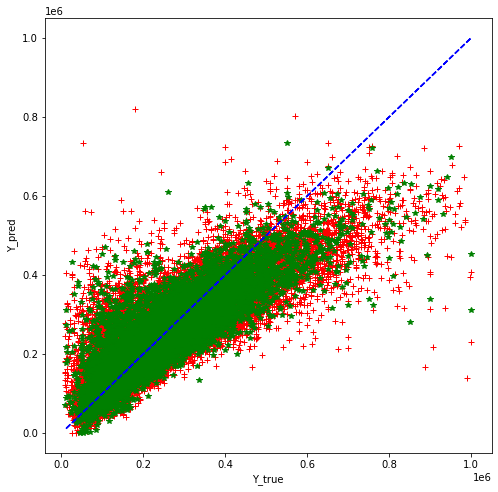

In [46]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(Y_train, y_pred, marker='+', linestyle="", color="red")
ax.plot(Y_test, y_test_pred, marker='*', linestyle="", color="green")
ax.plot(Y_train, Y_train, linestyle="--", color="blue")
ax.set_xlabel("Y_true")
ax.set_ylabel("Y_pred")
plt.show()

## TabResNet

In [47]:
tab_preprocessor = TabPreprocessor(
    cat_embed_cols=cat_embed_cols, 
    continuous_cols=continuous_cols,
    auto_embed_dim =True
    # type: ignore[arg-type]
)
X_tab = tab_preprocessor.fit_transform(X_train)

In [48]:
from pytorch_widedeep.models import TabResnet

tabresnet = TabResnet(
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input, 
    continuous_cols=continuous_cols,
    mlp_batchnorm =True,
    blocks_dims=[200, 100, 100],
    mlp_hidden_dims=[100, 50],
)
model = WideDeep(deeptabular=tabresnet)

In [49]:
trainer = Trainer(model, objective="mean_absolute_error", metrics=[Accuracy],
                 device='cpu', num_workers=4)
trainer.fit(
    X_tab=X_tab,
    target=target,
    n_epochs=10,
    batch_size=64,
    val_split=0.2
)

valid: 100%|██████████| 199/199 [00:26<00:00,  7.58it/s, loss=3.6e+4, metrics={'acc': 0.0}] 


In [50]:
name = 'TabResNet'
y_pred = trainer.predict(X_tab = tab_preprocessor.transform(X_train))
y_test_pred = trainer.predict(X_tab = tab_preprocessor.transform(X_test))
MAE_train = metrics.mean_absolute_error(Y_train, y_pred)
MAE_test = metrics.mean_absolute_error(Y_test, y_test_pred)
R2_train = adjusted_r2(Y_train, y_pred, X_train_norm.shape[0])
R2_test = adjusted_r2(Y_test, y_test_pred, X_test_norm.shape[0])
print(f"Mean absolute Error train set = {MAE_train}")
print(f"Mean absolute Error test set = {MAE_test}")
print(f"Adjusted R2 train set = {R2_train}")
print(f"Adjusted R2 Error train set = {R2_test}")
print(f"Mean percentage error train set = {metrics.mean_absolute_percentage_error(Y_train, y_pred)}")
print(f"Mean percentage error test set = {metrics.mean_absolute_percentage_error(Y_test, y_test_pred)}")

result.drop(result[result['model']==name].index, inplace=True)
result = result.append({'model':name,
                        'MAE_train':MAE_train , 'MAE_test':MAE_test, 
                        'R2_train': R2_train, 'R2_test':R2_test,
                        'y_train_pred': y_pred, 'y_pred_test':y_test_pred}, ignore_index=True)

predict: 100%|██████████| 249/249 [00:26<00:00,  9.54it/s]


Mean absolute Error train set = 36623.47485045898
Mean absolute Error test set = 36303.806821162994
Adjusted R2 train set = 0.7840997978434824
Adjusted R2 Error train set = 0.780479960498206
Mean percentage error train set = 0.19005366180011057
Mean percentage error test set = 0.18920151577972333


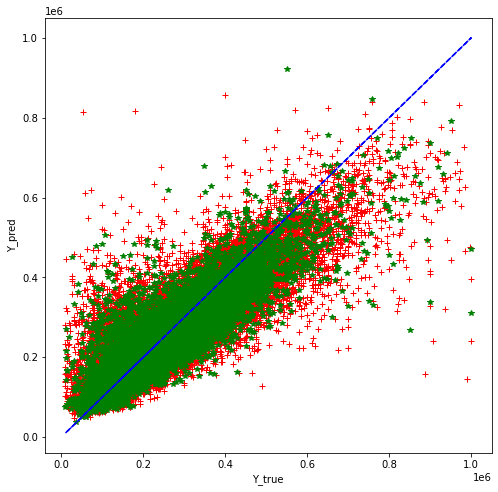

In [51]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(Y_train, y_pred, marker='+', linestyle="", color="red")
ax.plot(Y_test, y_test_pred, marker='*', linestyle="", color="green")
ax.plot(Y_train, Y_train, linestyle="--", color="blue")
ax.set_xlabel("Y_true")
ax.set_ylabel("Y_pred")
plt.show()

## Tab Transformers

In [52]:
from pytorch_widedeep.preprocessing import TabPreprocessor

In [53]:
fca

In [54]:
from pytorch_widedeep.models import TabTransformer

tabtransformer = TabTransformer(
    tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=continuous_cols,
    add_shared_embed =True,
    #n_heads =8,
    #n_blocks = 4,
)
#model = WideDeep(deeptabular=tabtransformer)

In [55]:
model = WideDeep(deeptabular=tabtransformer)

In [56]:
trainer = Trainer(model, objective="mean_absolute_error", metrics=[Accuracy],
                 device='cpu', num_workers=4,
                 )
trainer.fit(
    X_tab=X_tab,
    target=target,
    n_epochs=10,
    batch_size=64,
    val_split=0.2
)

valid: 100%|██████████| 199/199 [00:27<00:00,  7.13it/s, loss=3.52e+4, metrics={'acc': 0.0}]


In [57]:
name = 'TabTransformers'
y_pred = trainer.predict(X_tab = tab_preprocessor.transform(X_train))
y_test_pred = trainer.predict(X_tab = tab_preprocessor.transform(X_test))
MAE_train = metrics.mean_absolute_error(Y_train, y_pred)
MAE_test = metrics.mean_absolute_error(Y_test, y_test_pred)
R2_train = adjusted_r2(Y_train, y_pred, X_train_norm.shape[0])
R2_test = adjusted_r2(Y_test, y_test_pred, X_test_norm.shape[0])
print(f"Mean absolute Error train set = {MAE_train}")
print(f"Mean absolute Error test set = {MAE_test}")
print(f"Adjusted R2 train set = {R2_train}")
print(f"Adjusted R2 Error train set = {R2_test}")
print(f"Mean percentage error train set = {metrics.mean_absolute_percentage_error(Y_train, y_pred)}")
print(f"Mean percentage error test set = {metrics.mean_absolute_percentage_error(Y_test, y_test_pred)}")

result.drop(result[result['model']==name].index, inplace=True)
result = result.append({'model':name,
                        'MAE_train':MAE_train , 'MAE_test':MAE_test, 
                        'R2_train': R2_train, 'R2_test':R2_test,
                        'y_train_pred': y_pred, 'y_pred_test':y_test_pred}, ignore_index=True)

predict: 100%|██████████| 249/249 [00:28<00:00,  8.76it/s]


Mean absolute Error train set = 35808.171095228485
Mean absolute Error test set = 35479.98318231653
Adjusted R2 train set = 0.7874525955330071
Adjusted R2 Error train set = 0.7828038882695061
Mean percentage error train set = 0.18368650769866696
Mean percentage error test set = 0.18345792098506675


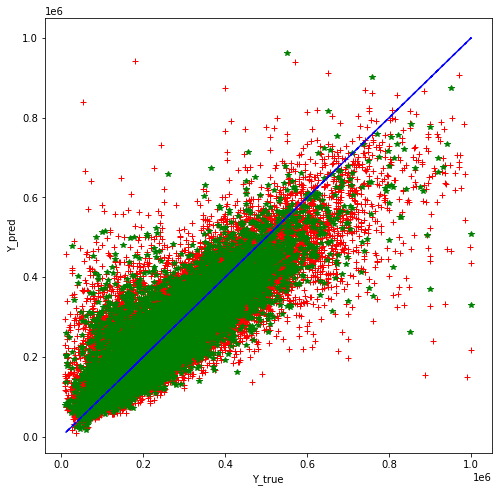

In [58]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(Y_train, y_pred, marker='+', linestyle="", color="red")
ax.plot(Y_test, y_test_pred, marker='*', linestyle="", color="green")
ax.plot(Y_train, Y_train, linestyle="--", color="blue")
ax.set_xlabel("Y_true")
ax.set_ylabel("Y_pred")
plt.show()

In [59]:
result

,model,MAE_train,MAE_test,R2_train,R2_test,y_train_pred,y_pred_test
0,XGBoost,28113.012247,32392.956293,0.874775,0.808713,"[237445.19, 71319.25, 137155.17, 278218.84, 38...","[407748.16, 235161.02, 103339.07, 265884.8, 33..."
1,XGBoost_opt,22505.545215,31863.705978,0.923279,0.808018,"[238209.48, 89065.734, 135762.5, 274853.75, 38...","[407152.12, 238140.97, 104171.91, 262500.25, 3..."
2,cateboost,24971.590567,30711.336680,0.872232,0.816633,"[242020.15824361675, 86352.32808918788, 130867...","[379793.8524331677, 245418.51505245434, 94961...."
3,NN_l-10_n-128,37253.751704,36754.702748,0.776596,0.772241,"[[245355.98], [76420.2], [140200.34], [294752....","[[366981.56], [248575.64], [105731.375], [2433..."
4,NN_l-15_n-256,37138.422917,36896.194336,0.781828,0.774146,"[[257865.03], [83734.61], [144685.4], [292029....","[[386602.2], [266663.97], [104095.77], [254444..."
5,TabMLP,39778.239255,39246.786995,0.750942,0.748271,"[245096.47, 48442.555, 136855.25, 321337.34, 3...","[376755.62, 239525.62, 118367.02, 243126.55, 3..."
6,TabResNet,36623.474850,36303.806821,0.784100,0.780480,"[228194.67, 77392.49, 127062.516, 275539.44, 3...","[380808.8, 232653.86, 113950.98, 238678.33, 32..."
7,TabTransformers,35808.171095,35479.983182,0.787453,0.782804,"[226676.08, 65536.7, 120386.56, 306195.47, 351...","[421179.12, 244011.73, 97976.36, 257955.98, 32..."


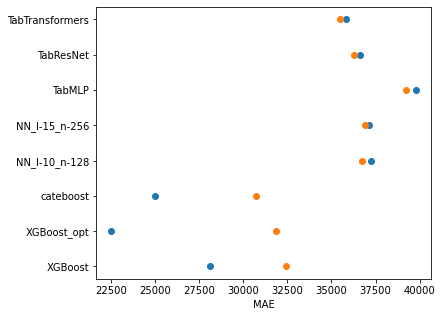

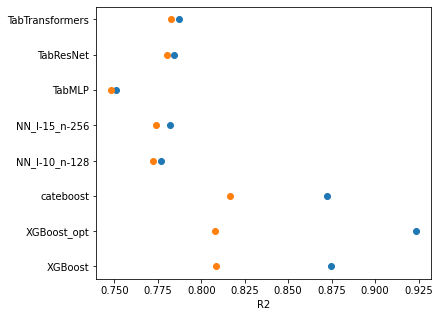

In [60]:
for metric in ['MAE', 'R2'] : 
    fig, ax= plt.subplots(figsize=(6,5))
    ax.scatter(result[f'{metric}_train'], result['model'])
    ax.scatter(result[f'{metric}_test'], result['model'])
    ax.set_xlabel(metric)
    plt.show()

Les modèles XGBoost et cateboost donnent les meilleurs performances mais sont sensibles au surapprentissage.  
Le modèle TabMLP est le modèle le moins précis.  
Les modèle TabTransformers et TabResNet donnent des résultats meilleurs qu'un NN mais moins bon que les modèles CateBoost et XGBoost.  
Essayons de combiner l'ensemble de ces modèles pour voir si en moyenne les erreurs s'annulent.

## Modele averaging
On sélectionne les modèles suivant pour moyenner les résultats et observer si une amélioration est possible.  
- XGBoost_opt
- cateboost
- TabResNet
- Tab Transformers
- NN_l-10_n-256
- NN_l-15_n-128

In [67]:
models = ['XGBoost','XGBoost_opt', 'cateboost', 'TabResNet', 'TabTransformers', 'NN_l-15_n-256', 'NN_l-10_n-128']
result[result['model'].isin(models)]

,model,MAE_train,MAE_test,R2_train,R2_test,y_train_pred,y_pred_test
0,XGBoost,28113.012247,32392.956293,0.874775,0.808713,"[237445.19, 71319.25, 137155.17, 278218.84, 38...","[407748.16, 235161.02, 103339.07, 265884.8, 33..."
1,XGBoost_opt,22505.545215,31863.705978,0.923279,0.808018,"[238209.48, 89065.734, 135762.5, 274853.75, 38...","[407152.12, 238140.97, 104171.91, 262500.25, 3..."
2,cateboost,24971.590567,30711.336680,0.872232,0.816633,"[242020.15824361675, 86352.32808918788, 130867...","[379793.8524331677, 245418.51505245434, 94961...."
3,NN_l-10_n-128,37253.751704,36754.702748,0.776596,0.772241,"[[245355.98], [76420.2], [140200.34], [294752....","[[366981.56], [248575.64], [105731.375], [2433..."
4,NN_l-15_n-256,37138.422917,36896.194336,0.781828,0.774146,"[[257865.03], [83734.61], [144685.4], [292029....","[[386602.2], [266663.97], [104095.77], [254444..."
6,TabResNet,36623.474850,36303.806821,0.784100,0.780480,"[228194.67, 77392.49, 127062.516, 275539.44, 3...","[380808.8, 232653.86, 113950.98, 238678.33, 32..."
7,TabTransformers,35808.171095,35479.983182,0.787453,0.782804,"[226676.08, 65536.7, 120386.56, 306195.47, 351...","[421179.12, 244011.73, 97976.36, 257955.98, 32..."


In [68]:
y_train_pred = np.mean(np.concatenate([y.reshape((-1,1)) 
                                       for y in result[result['model'].isin(models)]['y_train_pred']], 
                                      axis=1), 
                       axis=1)
y_test_pred = np.mean(np.concatenate([y.reshape((-1,1)) 
                                      for y in result[result['model'].isin(models)]['y_pred_test']], 
                                     axis=1), 
                      axis=1)

In [69]:
name = 'modele averaging'
MAE_train = metrics.mean_absolute_error(Y_train, y_train_pred)
MAE_test = metrics.mean_absolute_error(Y_test, y_test_pred)
R2_train = adjusted_r2(Y_train, y_train_pred, X_train_norm.shape[0])
R2_test = adjusted_r2(Y_test, y_test_pred, X_test_norm.shape[0])
print(f"Mean absolute Error train set = {MAE_train}")
print(f"Mean absolute Error test set = {MAE_test}")
print(f"Adjusted R2 train set = {R2_train}")
print(f"Adjusted R2 Error train set = {R2_test}")
print(f"Mean percentage error train set = {metrics.mean_absolute_percentage_error(Y_train, y_train_pred)}")
print(f"Mean percentage error test set = {metrics.mean_absolute_percentage_error(Y_test, y_test_pred)}")

result.drop(result[result['model']==name].index, inplace=True)
result = result.append({'model':name,
                        'MAE_train':MAE_train , 'MAE_test':MAE_test, 
                        'R2_train': R2_train, 'R2_test':R2_test,
                        'y_train_pred': y_train_pred, 'y_pred_test':y_test_pred}, ignore_index=True)

Mean absolute Error train set = 29823.766948610588
Mean absolute Error test set = 32126.34722184799
Adjusted R2 train set = 0.8509861282904357
Adjusted R2 Error train set = 0.8113750815071797
Mean percentage error train set = 0.15828254167325972
Mean percentage error test set = 0.17063201963465313


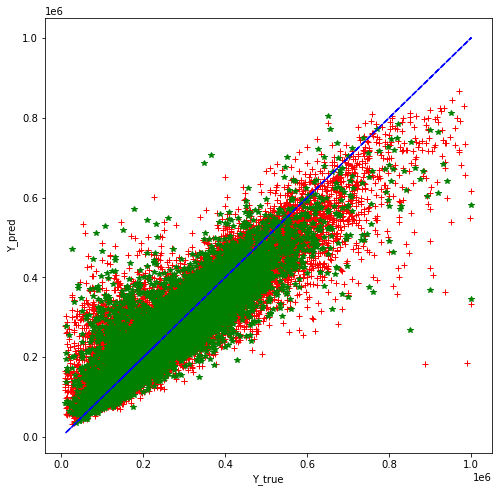

In [70]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(Y_train, y_train_pred, marker='+', linestyle="", color="red")
ax.plot(Y_test, y_test_pred, marker='*', linestyle="", color="green")
ax.plot(Y_train, Y_train, linestyle="--", color="blue")
ax.set_xlabel("Y_true")
ax.set_ylabel("Y_pred")
plt.show()

In [71]:
result

,model,MAE_train,MAE_test,R2_train,R2_test,y_train_pred,y_pred_test
0,XGBoost,28113.012247,32392.956293,0.874775,0.808713,"[237445.19, 71319.25, 137155.17, 278218.84, 38...","[407748.16, 235161.02, 103339.07, 265884.8, 33..."
1,XGBoost_opt,22505.545215,31863.705978,0.923279,0.808018,"[238209.48, 89065.734, 135762.5, 274853.75, 38...","[407152.12, 238140.97, 104171.91, 262500.25, 3..."
2,cateboost,24971.590567,30711.336680,0.872232,0.816633,"[242020.15824361675, 86352.32808918788, 130867...","[379793.8524331677, 245418.51505245434, 94961...."
3,NN_l-10_n-128,37253.751704,36754.702748,0.776596,0.772241,"[[245355.98], [76420.2], [140200.34], [294752....","[[366981.56], [248575.64], [105731.375], [2433..."
4,NN_l-15_n-256,37138.422917,36896.194336,0.781828,0.774146,"[[257865.03], [83734.61], [144685.4], [292029....","[[386602.2], [266663.97], [104095.77], [254444..."
5,TabMLP,39778.239255,39246.786995,0.750942,0.748271,"[245096.47, 48442.555, 136855.25, 321337.34, 3...","[376755.62, 239525.62, 118367.02, 243126.55, 3..."
6,TabResNet,36623.474850,36303.806821,0.784100,0.780480,"[228194.67, 77392.49, 127062.516, 275539.44, 3...","[380808.8, 232653.86, 113950.98, 238678.33, 32..."
7,TabTransformers,35808.171095,35479.983182,0.787453,0.782804,"[226676.08, 65536.7, 120386.56, 306195.47, 351...","[421179.12, 244011.73, 97976.36, 257955.98, 32..."
8,modele averaging,29823.766949,32126.347222,0.850986,0.811375,"[239395.22796337382, 78545.9028966697, 133731....","[392895.11731188104, 244375.10036463634, 10346..."


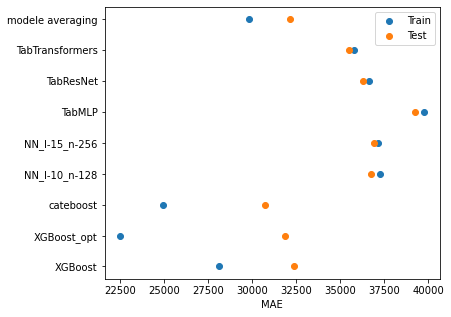

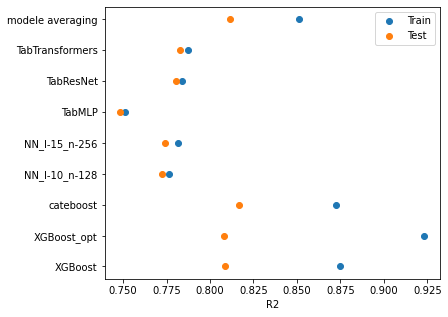

In [72]:
for metric in ['MAE', 'R2'] : 
    fig, ax= plt.subplots(figsize=(6,5))
    ax.scatter(result[f'{metric}_train'], result['model'], label='Train')
    ax.scatter(result[f'{metric}_test'], result['model'], label='Test')
    ax.set_xlabel(metric)
    plt.legend()
    plt.show()

## Selection des features importantes

### f_regression

In [73]:
from sklearn.feature_selection import f_regression, SelectKBest

In [74]:
f_score, p_value = f_regression(X, Y)
df = pd.DataFrame(columns=['f_score', 'p_value'],index=X.columns)
df['f_score'] = f_score
df['p_value'] = p_value
df.sort_values('f_score',ascending=False).reset_index()

,index,f_score,p_value
0,loyer_moyen,83938.885698,0.000000e+00
1,surface_reelle_bati,82906.047942,0.000000e+00
2,nombre_pieces_principales,53079.749787,0.000000e+00
3,type_local_enc,48283.341453,0.000000e+00
4,surface_terrain,33517.602746,0.000000e+00
5,Dépendance,8742.417237,0.000000e+00
6,Taux Propriété,6341.257729,0.000000e+00
7,Evolution Pop %,5753.567483,0.000000e+00
8,Dynamique Démographique INSEE,5256.604070,0.000000e+00
9,n_etab_sup_10km,4325.226390,0.000000e+00


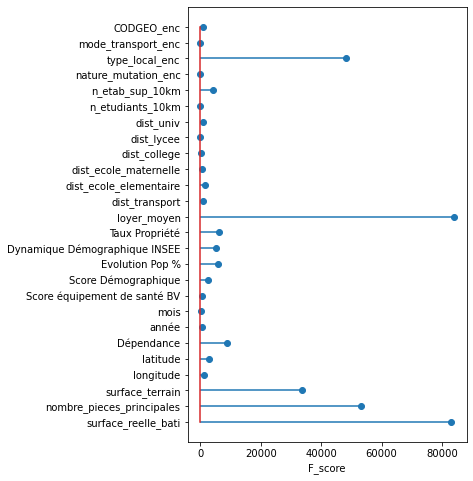

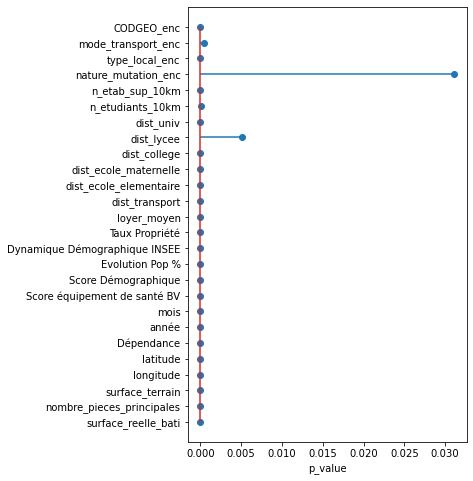

In [75]:
fig, ax = plt.subplots(figsize=(5,8))
ax.stem(df.index, df['f_score'], orientation='horizontal')
ax.set_xlabel('F_score')
plt.show()
fig, ax = plt.subplots(figsize=(5,8))
ax.stem(df.index, df['p_value'], orientation='horizontal')
ax.set_xlabel('p_value')
plt.show()

### Lasso regularization

In [76]:
from sklearn.linear_model import Lasso

In [77]:
lasso=Lasso(max_iter=10000, fit_intercept=False, alpha=100)
lasso.fit(X_train_norm,Y_train)

Lasso(alpha=100, fit_intercept=False, max_iter=10000)

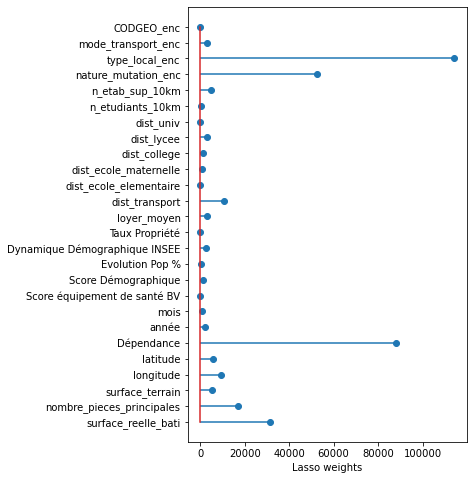

                                    f_score        p_value      lasso_abs
type_local_enc                 48283.341453   0.000000e+00  114101.818303
Dépendance                      8742.417237   0.000000e+00   87953.727475
nature_mutation_enc                4.649756   3.106094e-02   52593.194349
surface_reelle_bati            82906.047942   0.000000e+00   31260.605349
nombre_pieces_principales      53079.749787   0.000000e+00   16980.101605
dist_transport                   943.597428  5.274166e-206   10716.227817
longitude                       1079.184226  4.174028e-235    9318.124671
latitude                        2769.315160   0.000000e+00    5788.192930
surface_terrain                33517.602746   0.000000e+00    5374.435528
n_etab_sup_10km                 4325.226390   0.000000e+00    4882.534308
dist_lycee                         7.859977   5.055326e-03    3219.300925
mode_transport_enc                12.544549   3.975908e-04    3073.066005
loyer_moyen                    83938.8

In [78]:
df['lasso_abs'] = np.abs(lasso.coef_)
fig, ax = plt.subplots(figsize=(5,8))
ax.stem(X.columns, np.abs(lasso.coef_), orientation='horizontal')
ax.set_xlabel('Lasso weights')
plt.show()
print(df.sort_values('lasso_abs', ascending=False))

### Random Forest

In [79]:
from sklearn.ensemble import RandomForestRegressor

In [80]:
rf = RandomForestRegressor()
rf.fit(X,Y)

RandomForestRegressor()

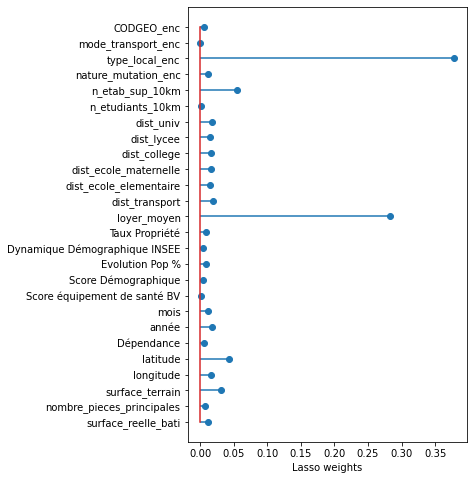

,f_score,p_value,lasso_abs,RandomForest
type_local_enc,48283.341453,0.000000e+00,114101.818303,0.377921
loyer_moyen,83938.885698,0.000000e+00,2915.350402,0.283069
n_etab_sup_10km,4325.226390,0.000000e+00,4882.534308,0.054480
latitude,2769.315160,0.000000e+00,5788.192930,0.043527
surface_terrain,33517.602746,0.000000e+00,5374.435528,0.030965
dist_transport,943.597428,5.274166e-206,10716.227817,0.018350
année,726.046365,3.377718e-159,1992.815916,0.017073
dist_univ,784.189484,1.011900e-171,36.663341,0.017021
dist_ecole_maternelle,701.790358,5.704475e-154,798.714788,0.015668
longitude,1079.184226,4.174028e-235,9318.124671,0.015441


In [81]:
fig, ax = plt.subplots(figsize=(5,8))
ax.stem(X.columns, rf.feature_importances_, orientation='horizontal')
ax.set_xlabel('Lasso weights')
plt.show()
df['RandomForest'] = rf.feature_importances_
df.sort_values('RandomForest', ascending=False)

### XGBoost

In [82]:
model = xgb.XGBRegressor()
model.fit(X, Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

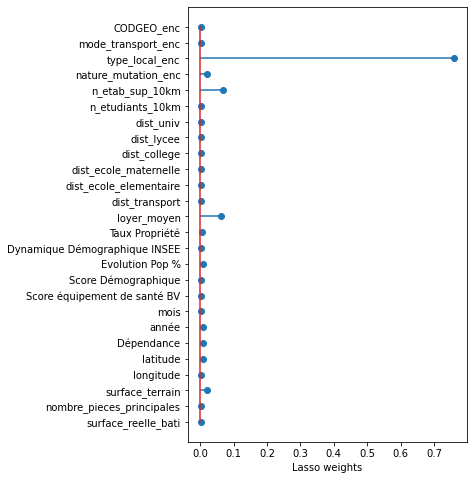

,f_score,p_value,lasso_abs,RandomForest,XGBoost
type_local_enc,48283.341453,0.000000e+00,114101.818303,0.377921,0.759464
n_etab_sup_10km,4325.226390,0.000000e+00,4882.534308,0.054480,0.069136
loyer_moyen,83938.885698,0.000000e+00,2915.350402,0.283069,0.061957
surface_terrain,33517.602746,0.000000e+00,5374.435528,0.030965,0.020290
nature_mutation_enc,4.649756,3.106094e-02,52593.194349,0.011352,0.019126
Evolution Pop %,5753.567483,0.000000e+00,406.469426,0.007819,0.009487
latitude,2769.315160,0.000000e+00,5788.192930,0.043527,0.009162
Dépendance,8742.417237,0.000000e+00,87953.727475,0.006254,0.007631
année,726.046365,3.377718e-159,1992.815916,0.017073,0.007120
Taux Propriété,6341.257729,0.000000e+00,0.000000,0.008298,0.004960


In [83]:
fig, ax = plt.subplots(figsize=(5,8))
ax.stem(X.columns, model.feature_importances_, orientation='horizontal')
ax.set_xlabel('Lasso weights')
plt.show()
df['XGBoost'] = model.feature_importances_
df.sort_values('XGBoost', ascending=False)

### importante features

In [84]:
feat_f_score = df[df['f_score']>1000].index.tolist()
feat_lasso = df[df['lasso_abs']>1000].index.tolist()
feat_rf = df[df['RandomForest']>0.01].index.tolist()
feat_xgb = df[df['XGBoost']>0.01].index.tolist()
feat_all = feat_f_score+feat_lasso+feat_rf+feat_xgb

<AxesSubplot:>

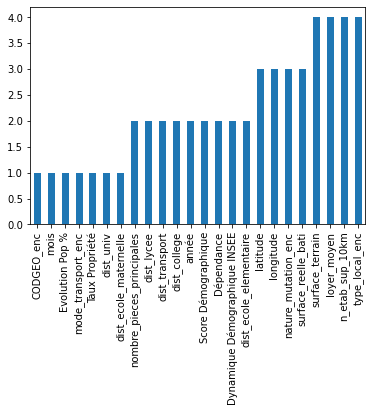

In [85]:
count = {}
for val in np.unique(feat_all) :
    count[val] = feat_all.count(val)
count=pd.Series(count)
count.sort_values().plot(kind='bar')

In [86]:
keep_var = count[count>2].index.tolist()+['Dépendance', 'nombre_pieces_principales']
keep_var

['latitude',
 'longitude',
 'loyer_moyen',
 'n_etab_sup_10km',
 'nature_mutation_enc',
 'surface_reelle_bati',
 'surface_terrain',
 'type_local_enc',
 'Dépendance',
 'nombre_pieces_principales']

## Modelisation avec les features importantes

In [87]:
X = X[keep_var]

In [88]:
categ_types = ['int16', 'int32', 'int64']
categ_var = list(X[keep_var].select_dtypes(include=categ_types).columns)
print(f"Nombre de variables catégorielles : {len(categ_var)}")
print(f"Liste des variables de catégories : {', '.join(categ_var)}")

Nombre de variables catégorielles : 5
Liste des variables de catégories : n_etab_sup_10km, nature_mutation_enc, type_local_enc, Dépendance, nombre_pieces_principales


In [89]:
cont_types = ['float16', 'float32', 'float64']
cont_var = list(X[keep_var].select_dtypes(include=cont_types).columns)
print(f"Nombre de variables catégorielles : {len(cont_var)}")
print(f"Liste des variables de catégories : {', '.join(cont_var)}")

Nombre de variables catégorielles : 5
Liste des variables de catégories : latitude, longitude, loyer_moyen, surface_reelle_bati, surface_terrain


In [90]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)

In [91]:
preprocessor = ColumnTransformer(remainder='passthrough', 
                                transformers=[
                                    ('std', StandardScaler() , cont_var)
                                ]
                                )
preprocessor.fit(X_train)
X_train_norm = preprocessor.transform(X_train)
X_test_norm = preprocessor.transform(X_test)

In [92]:
result_feat = pd.DataFrame(columns=['model', 'MAE_train', 'MAE_test', 'R2_train', 'R2_test', 'y_train_pred', 'y_pred_test'])

### XGBoost

In [93]:
name = "XGBoost"
model = xgb.XGBRegressor()
model.fit(X_train_norm, Y_train)
y_pred = model.predict(X_train_norm)
y_test_pred = model.predict(X_test_norm)
MAE_train = metrics.mean_absolute_error(Y_train, y_pred)
MAE_test = metrics.mean_absolute_error(Y_test, y_test_pred)
R2_train = adjusted_r2(Y_train, y_pred, X_train_norm.shape[0])
R2_test = adjusted_r2(Y_test, y_test_pred, X_test_norm.shape[0])
print(f"Mean absolute Error train set = {MAE_train}")
print(f"Mean absolute Error test set = {MAE_test}")
print(f"Adjusted R2 train set = {R2_train}")
print(f"Adjusted R2 Error train set = {R2_test}")
print(f"Mean percentage error train set = {metrics.mean_absolute_percentage_error(Y_train, y_pred)}")
print(f"Mean percentage error test set = {metrics.mean_absolute_percentage_error(Y_test, y_test_pred)}")

result_feat.drop(result_feat[result_feat['model']==name].index, inplace=True)
result_feat = result_feat.append({'model':name,
                        'MAE_train':MAE_train , 'MAE_test':MAE_test, 
                        'R2_train': R2_train, 'R2_test':R2_test,
                       'y_train_pred': y_pred, 'y_pred_test':y_test_pred}, ignore_index=True)

Mean absolute Error train set = 31160.216803057614
Mean absolute Error test set = 34403.079787218696
Adjusted R2 train set = 0.848843172454308
Adjusted R2 Error train set = 0.790727203642171
Mean percentage error train set = 0.1651105848849241
Mean percentage error test set = 0.18203568599637268


In [94]:
name = "XGBoost_opt"
model = xgb.XGBRegressor(n_estimators=300, max_depth=6)
model.fit(X_train_norm, Y_train)
y_pred = model.predict(X_train_norm)
y_test_pred = model.predict(X_test_norm)
MAE_train = metrics.mean_absolute_error(Y_train, y_pred)
MAE_test = metrics.mean_absolute_error(Y_test, y_test_pred)
R2_train = adjusted_r2(Y_train, y_pred, X_train_norm.shape[0])
R2_test = adjusted_r2(Y_test, y_test_pred, X_test_norm.shape[0])
print(f"Mean absolute Error train set = {MAE_train}")
print(f"Mean absolute Error test set = {MAE_test}")
print(f"Adjusted R2 train set = {R2_train}")
print(f"Adjusted R2 Error train set = {R2_test}")
print(f"Mean percentage error train set = {metrics.mean_absolute_percentage_error(Y_train, y_pred)}")
print(f"Mean percentage error test set = {metrics.mean_absolute_percentage_error(Y_test, y_test_pred)}")
result_feat.drop(result_feat[result_feat['model']==name].index, inplace=True)
result_feat = result_feat.append({'model':name,
                        'MAE_train':MAE_train , 'MAE_test':MAE_test, 
                        'R2_train': R2_train, 'R2_test':R2_test,
                       'y_train_pred': y_pred, 'y_pred_test':y_test_pred}, ignore_index=True)

Mean absolute Error train set = 26216.970444920888
Mean absolute Error test set = 33862.67332363253
Adjusted R2 train set = 0.8961216712881842
Adjusted R2 Error train set = 0.7909404918577273
Mean percentage error train set = 0.14076725386678882
Mean percentage error test set = 0.17715339392538804


In [95]:
result_feat

,model,MAE_train,MAE_test,R2_train,R2_test,y_train_pred,y_pred_test
0,XGBoost,31160.216803,34403.079787,0.848843,0.790727,"[249526.5, 81813.945, 136170.6, 266479.88, 369...","[374459.06, 247731.05, 94380.445, 251060.19, 3..."
1,XGBoost_opt,26216.970445,33862.673324,0.896122,0.790940,"[249218.08, 90068.92, 137118.52, 268140.66, 37...","[411764.9, 248552.3, 89393.41, 236453.22, 3134..."


### Cateboost

In [96]:
categ_var_i = []
for var in categ_var : 
    categ_var_i.append(X.columns.get_loc(var))
train_pool = Pool(X_train, 
                  Y_train, 
                  cat_features=categ_var_i)
test_pool = Pool(X_test, 
                 Y_test,
                 cat_features=categ_var_i) 

In [97]:
name = 'cateboost'
model = CatBoostRegressor(iterations=1000, 
                                  depth=10, 
                                  learning_rate=0.1, 
                                  loss_function='MAE',
                                  verbose=0,
                                  #loss_function=metrics.mean_absolute_percentage_error,
                                  use_best_model=True)
model.fit(train_pool, eval_set=test_pool)
y_pred = model.predict(train_pool)
y_test_pred = model.predict(test_pool)
MAE_train = metrics.mean_absolute_error(Y_train, y_pred)
MAE_test = metrics.mean_absolute_error(Y_test, y_test_pred)
R2_train = adjusted_r2(Y_train, y_pred, X_train_norm.shape[0])
R2_test = adjusted_r2(Y_test, y_test_pred, X_test_norm.shape[0])
print(f"Mean absolute Error train set = {MAE_train}")
print(f"Mean absolute Error test set = {MAE_test}")
print(f"Adjusted R2 train set = {R2_train}")
print(f"Adjusted R2 Error train set = {R2_test}")
print(f"Mean percentage error train set = {metrics.mean_absolute_percentage_error(Y_train, y_pred)}")
print(f"Mean percentage error test set = {metrics.mean_absolute_percentage_error(Y_test, y_test_pred)}")
result_feat.drop(result_feat[result_feat['model']==name].index, inplace=True)
result_feat = result_feat.append({'model':name,
                        'MAE_train':MAE_train , 'MAE_test':MAE_test, 
                        'R2_train': R2_train, 'R2_test':R2_test,
                       'y_train_pred': y_pred, 'y_pred_test':y_test_pred}, ignore_index=True)

Mean absolute Error train set = 28610.931098232777
Mean absolute Error test set = 33198.83687966712
Adjusted R2 train set = 0.8481174356233236
Adjusted R2 Error train set = 0.7973570104895129
Mean percentage error train set = 0.15085955741067125
Mean percentage error test set = 0.17521096780259104


### Reseau de neurones

In [98]:
#for couche in [10, 15] :
#    for neurones in [256] :
for couche, neurones in [(10,128), (15,256)] :
        name = f'NN_l-{couche}_n-{neurones}'
        print(couche, neurones)
        model = create_nn(10, 1, nlayers=couche, nneuron=neurones)
        model.compile(optimizer='adam',
                      loss="mean_absolute_error",
                      metrics=['accuracy'])
        history = model.fit(X_train_norm, Y_train, 
                            validation_data=(X_test_norm, Y_test),
                            batch_size=128,
                            epochs=50,
                            verbose=0)
        
        y_pred = model.predict(X_train_norm)
        y_test_pred = model.predict(X_test_norm)
        MAE_train = metrics.mean_absolute_error(Y_train, y_pred)
        MAE_test = metrics.mean_absolute_error(Y_test, y_test_pred)
        R2_train = adjusted_r2(Y_train, y_pred, X_train_norm.shape[0])
        R2_test = adjusted_r2(Y_test, y_test_pred, X_test_norm.shape[0])
        print(f"Mean absolute Error train set = {MAE_train}")
        print(f"Mean absolute Error test set = {MAE_test}")
        print(f"Adjusted R2 train set = {R2_train}")
        print(f"Adjusted R2 Error train set = {R2_test}")
        print(f"Mean percentage error train set = {metrics.mean_absolute_percentage_error(Y_train, y_pred)}")
        print(f"Mean percentage error test set = {metrics.mean_absolute_percentage_error(Y_test, y_test_pred)}")
        
        result_feat.drop(result_feat[result_feat['model']==name].index, inplace=True)
        result_feat = result_feat.append({'model':name,
                                          'MAE_train':MAE_train , 'MAE_test':MAE_test, 
                                          'R2_train': R2_train, 'R2_test':R2_test,
                                           'y_train_pred': y_pred, 'y_pred_test':y_test_pred}, ignore_index=True)

10 128
Mean absolute Error train set = 35589.353962135254
Mean absolute Error test set = 35625.73862193959
Adjusted R2 train set = 0.7902932726457672
Adjusted R2 Error train set = 0.7821149324443243
Mean percentage error train set = 0.18725241603730033
Mean percentage error test set = 0.1889262055916709
15 256
Mean absolute Error train set = 46928.87568001779
Mean absolute Error test set = 47805.89390149939
Adjusted R2 train set = 0.6818605509341653
Adjusted R2 Error train set = 0.6462022087994663
Mean percentage error train set = 0.24771724074852497
Mean percentage error test set = 0.25448329922221546


### TabResnet

In [99]:
cat_embed_cols = categ_var
continuous_cols = cont_var
target = Y_train.values

In [100]:
tab_preprocessor = TabPreprocessor(
    cat_embed_cols=cat_embed_cols, 
    continuous_cols=continuous_cols,
    auto_embed_dim =True
    # type: ignore[arg-type]
)
X_tab = tab_preprocessor.fit_transform(X_train)

tabresnet = TabResnet(
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input, 
    continuous_cols=continuous_cols,
    mlp_batchnorm =True,
    blocks_dims=[200, 100, 100],
    mlp_hidden_dims=[100, 50],
)
model = WideDeep(deeptabular=tabresnet)

trainer = Trainer(model, objective="mean_absolute_error", metrics=[Accuracy],
                 device='cpu', num_workers=4)
trainer.fit(
    X_tab=X_tab,
    target=target,
    n_epochs=10,
    batch_size=64,
    val_split=0.2
)

valid: 100%|██████████| 199/199 [00:26<00:00,  7.48it/s, loss=3.87e+4, metrics={'acc': 0.0}]


In [101]:
name = 'TabResNet'
y_pred = trainer.predict(X_tab = tab_preprocessor.transform(X_train))
y_test_pred = trainer.predict(X_tab = tab_preprocessor.transform(X_test))
MAE_train = metrics.mean_absolute_error(Y_train, y_pred)
MAE_test = metrics.mean_absolute_error(Y_test, y_test_pred)
R2_train = adjusted_r2(Y_train, y_pred, X_train_norm.shape[0])
R2_test = adjusted_r2(Y_test, y_test_pred, X_test_norm.shape[0])
print(f"Mean absolute Error train set = {MAE_train}")
print(f"Mean absolute Error test set = {MAE_test}")
print(f"Adjusted R2 train set = {R2_train}")
print(f"Adjusted R2 Error train set = {R2_test}")
print(f"Mean percentage error train set = {metrics.mean_absolute_percentage_error(Y_train, y_pred)}")
print(f"Mean percentage error test set = {metrics.mean_absolute_percentage_error(Y_test, y_test_pred)}")

result_feat.drop(result_feat[result_feat['model']==name].index, inplace=True)
result_feat = result_feat.append({'model':name,
                                  'MAE_train':MAE_train , 'MAE_test':MAE_test, 
                                   'R2_train': R2_train, 'R2_test':R2_test,
                                    'y_train_pred': y_pred, 'y_pred_test':y_test_pred}, ignore_index=True)

predict: 100%|██████████| 249/249 [00:26<00:00,  9.44it/s]


Mean absolute Error train set = 39691.22995679531
Mean absolute Error test set = 38996.82776713361
Adjusted R2 train set = 0.7554891600485992
Adjusted R2 Error train set = 0.7547736216710144
Mean percentage error train set = 0.20538902430534023
Mean percentage error test set = 0.2035856441868354


### TabTransformer

In [102]:
tab_preprocessor = TabPreprocessor(
    embed_cols=cat_embed_cols, 
    continuous_cols=continuous_cols,
    auto_embed_dim =True,
    shared_embed=True )
X_tab = tab_preprocessor.fit_transform(X_train)

tabtransformer = TabTransformer(
    tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=continuous_cols,
    add_shared_embed =True,
)
model = WideDeep(deeptabular=tabtransformer)
trainer = Trainer(model, objective="mean_absolute_error", metrics=[Accuracy],
                 device='cpu', num_workers=4,
                 )
trainer.fit(
    X_tab=X_tab,
    target=target,
    n_epochs=10,
    batch_size=64,
    val_split=0.2
)


valid: 100%|██████████| 199/199 [00:27<00:00,  7.34it/s, loss=3.96e+4, metrics={'acc': 0.0}]


In [103]:
name = 'TabTransformers'
y_pred = trainer.predict(X_tab = tab_preprocessor.transform(X_train))
y_test_pred = trainer.predict(X_tab = tab_preprocessor.transform(X_test))
MAE_train = metrics.mean_absolute_error(Y_train, y_pred)
MAE_test = metrics.mean_absolute_error(Y_test, y_test_pred)
R2_train = adjusted_r2(Y_train, y_pred, X_train_norm.shape[0])
R2_test = adjusted_r2(Y_test, y_test_pred, X_test_norm.shape[0])
print(f"Mean absolute Error train set = {MAE_train}")
print(f"Mean absolute Error test set = {MAE_test}")
print(f"Adjusted R2 train set = {R2_train}")
print(f"Adjusted R2 Error train set = {R2_test}")
print(f"Mean percentage error train set = {metrics.mean_absolute_percentage_error(Y_train, y_pred)}")
print(f"Mean percentage error test set = {metrics.mean_absolute_percentage_error(Y_test, y_test_pred)}")

result_feat.drop(result_feat[result_feat['model']==name].index, inplace=True)
result_feat = result_feat.append({'model':name,
                                  'MAE_train':MAE_train , 'MAE_test':MAE_test, 
                                   'R2_train': R2_train, 'R2_test':R2_test,
                                    'y_train_pred': y_pred, 'y_pred_test':y_test_pred}, ignore_index=True)

predict: 100%|██████████| 249/249 [00:26<00:00,  9.36it/s] 


Mean absolute Error train set = 40303.042149127046
Mean absolute Error test set = 39798.49619424411
Adjusted R2 train set = 0.7508010254310808
Adjusted R2 Error train set = 0.7480894291745356
Mean percentage error train set = 0.21690275913612053
Mean percentage error test set = 0.21482745327519248


### Modele averaging

In [105]:
result_feat

,model,MAE_train,MAE_test,R2_train,R2_test,y_train_pred,y_pred_test
0,XGBoost,31160.216803,34403.079787,0.848843,0.790727,"[249526.5, 81813.945, 136170.6, 266479.88, 369...","[374459.06, 247731.05, 94380.445, 251060.19, 3..."
1,XGBoost_opt,26216.970445,33862.673324,0.896122,0.790940,"[249218.08, 90068.92, 137118.52, 268140.66, 37...","[411764.9, 248552.3, 89393.41, 236453.22, 3134..."
2,cateboost,28610.931098,33198.836880,0.848117,0.797357,"[243374.3559002353, 82409.33094048407, 135715....","[366061.01180758595, 250439.61415550034, 97407..."
3,NN_l-10_n-128,35589.353962,35625.738622,0.790293,0.782115,"[[238892.94], [76574.15], [130808.875], [29276...","[[372198.34], [238473.69], [109899.96], [23795..."
4,NN_l-15_n-256,46928.875680,47805.893901,0.681861,0.646202,"[[285695.12], [79827.26], [139616.66], [349146...","[[417852.62], [280553.94], [110355.586], [2616..."
5,TabResNet,39691.229957,38996.827767,0.755489,0.754774,"[260823.84, 76904.766, 116948.164, 297183.34, ...","[366340.2, 255847.66, 95556.54, 245526.17, 338..."
6,TabTransformers,40303.042149,39798.496194,0.750801,0.748089,"[259174.58, 81400.3, 122360.7, 325695.97, 3404...","[375815.6, 250324.98, 103214.92, 261270.9, 333..."


In [104]:
models = ['XGBoost', 'XGBoost_opt', 'cateboost', 'TabResNet', 'TabTransformers', 'NN_l-10_n-128']
result_feat[result_feat['model'].isin(models)]

,model,MAE_train,MAE_test,R2_train,R2_test,y_train_pred,y_pred_test
0,XGBoost,31160.216803,34403.079787,0.848843,0.790727,"[249526.5, 81813.945, 136170.6, 266479.88, 369...","[374459.06, 247731.05, 94380.445, 251060.19, 3..."
1,XGBoost_opt,26216.970445,33862.673324,0.896122,0.790940,"[249218.08, 90068.92, 137118.52, 268140.66, 37...","[411764.9, 248552.3, 89393.41, 236453.22, 3134..."
2,cateboost,28610.931098,33198.836880,0.848117,0.797357,"[243374.3559002353, 82409.33094048407, 135715....","[366061.01180758595, 250439.61415550034, 97407..."
3,NN_l-10_n-128,35589.353962,35625.738622,0.790293,0.782115,"[[238892.94], [76574.15], [130808.875], [29276...","[[372198.34], [238473.69], [109899.96], [23795..."
5,TabResNet,39691.229957,38996.827767,0.755489,0.754774,"[260823.84, 76904.766, 116948.164, 297183.34, ...","[366340.2, 255847.66, 95556.54, 245526.17, 338..."
6,TabTransformers,40303.042149,39798.496194,0.750801,0.748089,"[259174.58, 81400.3, 122360.7, 325695.97, 3404...","[375815.6, 250324.98, 103214.92, 261270.9, 333..."


In [106]:
y_train_pred = np.mean(np.concatenate([y.reshape((-1,1)) 
                                       for y in result_feat[result_feat['model'].isin(models)]['y_train_pred']], 
                                      axis=1), 
                       axis=1)
y_test_pred = np.mean(np.concatenate([y.reshape((-1,1)) 
                                      for y in result_feat[result_feat['model'].isin(models)]['y_pred_test']], 
                                     axis=1), 
                      axis=1)


In [107]:
name = 'modele averaging'
MAE_train = metrics.mean_absolute_error(Y_train, y_train_pred)
MAE_test = metrics.mean_absolute_error(Y_test, y_test_pred)
R2_train = adjusted_r2(Y_train, y_train_pred, X_train_norm.shape[0])
R2_test = adjusted_r2(Y_test, y_test_pred, X_test_norm.shape[0])
print(f"Mean absolute Error train set = {MAE_train}")
print(f"Mean absolute Error test set = {MAE_test}")
print(f"Adjusted R2 train set = {R2_train}")
print(f"Adjusted R2 Error train set = {R2_test}")
print(f"Mean percentage error train set = {metrics.mean_absolute_percentage_error(Y_train, y_train_pred)}")
print(f"Mean percentage error test set = {metrics.mean_absolute_percentage_error(Y_test, y_test_pred)}")
result_feat.drop(result_feat[result_feat['model']==name].index, inplace=True)
result_feat = result_feat.append({'model':name,
                                  'MAE_train':MAE_train , 'MAE_test':MAE_test, 
                                   'R2_train': R2_train, 'R2_test':R2_test,
                                    'y_train_pred': y_pred, 'y_pred_test':y_test_pred}, ignore_index=True)

Mean absolute Error train set = 32082.940403142504
Mean absolute Error test set = 34198.63718685878
Adjusted R2 train set = 0.835189000696896
Adjusted R2 Error train set = 0.7953911774505451
Mean percentage error train set = 0.1705524598955821
Mean percentage error test set = 0.18214254070941363


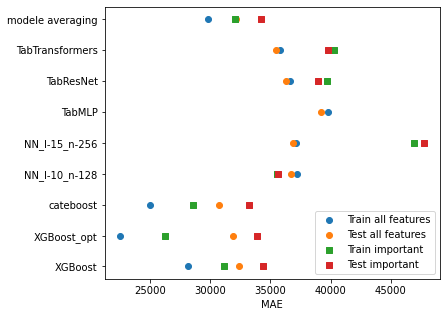

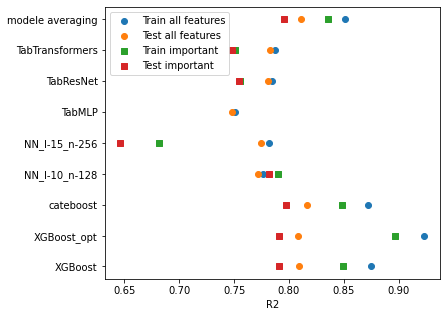

In [111]:
for metric in ['MAE', 'R2'] : 
    fig, ax= plt.subplots(figsize=(6,5))
    ax.scatter(result[f'{metric}_train'], result['model'], label='Train all features', marker='o')
    ax.scatter(result[f'{metric}_test'], result['model'], label='Test all features', marker='o')
    ax.scatter(result_feat[f'{metric}_train'], result_feat['model'], label='Train important', marker='s')
    ax.scatter(result_feat[f'{metric}_test'], result_feat['model'], label='Test important',marker='s')
    ax.set_xlabel(metric)
    plt.legend()
    plt.show()

In [109]:
result_feat

,model,MAE_train,MAE_test,R2_train,R2_test,y_train_pred,y_pred_test
0,XGBoost,31160.216803,34403.079787,0.848843,0.790727,"[249526.5, 81813.945, 136170.6, 266479.88, 369...","[374459.06, 247731.05, 94380.445, 251060.19, 3..."
1,XGBoost_opt,26216.970445,33862.673324,0.896122,0.790940,"[249218.08, 90068.92, 137118.52, 268140.66, 37...","[411764.9, 248552.3, 89393.41, 236453.22, 3134..."
2,cateboost,28610.931098,33198.836880,0.848117,0.797357,"[243374.3559002353, 82409.33094048407, 135715....","[366061.01180758595, 250439.61415550034, 97407..."
3,NN_l-10_n-128,35589.353962,35625.738622,0.790293,0.782115,"[[238892.94], [76574.15], [130808.875], [29276...","[[372198.34], [238473.69], [109899.96], [23795..."
4,NN_l-15_n-256,46928.875680,47805.893901,0.681861,0.646202,"[[285695.12], [79827.26], [139616.66], [349146...","[[417852.62], [280553.94], [110355.586], [2616..."
5,TabResNet,39691.229957,38996.827767,0.755489,0.754774,"[260823.84, 76904.766, 116948.164, 297183.34, ...","[366340.2, 255847.66, 95556.54, 245526.17, 338..."
6,TabTransformers,40303.042149,39798.496194,0.750801,0.748089,"[259174.58, 81400.3, 122360.7, 325695.97, 3404...","[375815.6, 250324.98, 103214.92, 261270.9, 333..."
7,modele averaging,32082.940403,34198.637187,0.835189,0.795391,"[259174.58, 81400.3, 122360.7, 325695.97, 3404...","[377773.1842595977, 248561.54767175004, 98308...."
